# **Overview**

This Colab notebook performs various tasks related to natural language processing (NLP) and information retrieval using LangChain, a library designed for building language model-based applications. The notebook processes a dataset of abstracts, splits the text into manageable chunks, embeds the text using a pre-trained model, and uses a combination of retrieval and generation to answer specific questions about the abstracts.

The workflow described in this notebook is an implementation of **Retrieval-Augmented Generation (RAG)**. RAG is a method that combines the strengths of both retrieval-based and generation-based approaches to improve the quality and relevance of the generated text. Here’s a detailed breakdown of how the notebook implements RAG:

## Components of RAG in this Notebook
1. Retrieval:

* Embedding the Documents: Using HuggingFaceEmbeddings, we embed the documents into a vector space.
* Vector Store (embdding store): The embedded documents are stored in a FAISS index, which allows for efficient similarity search.
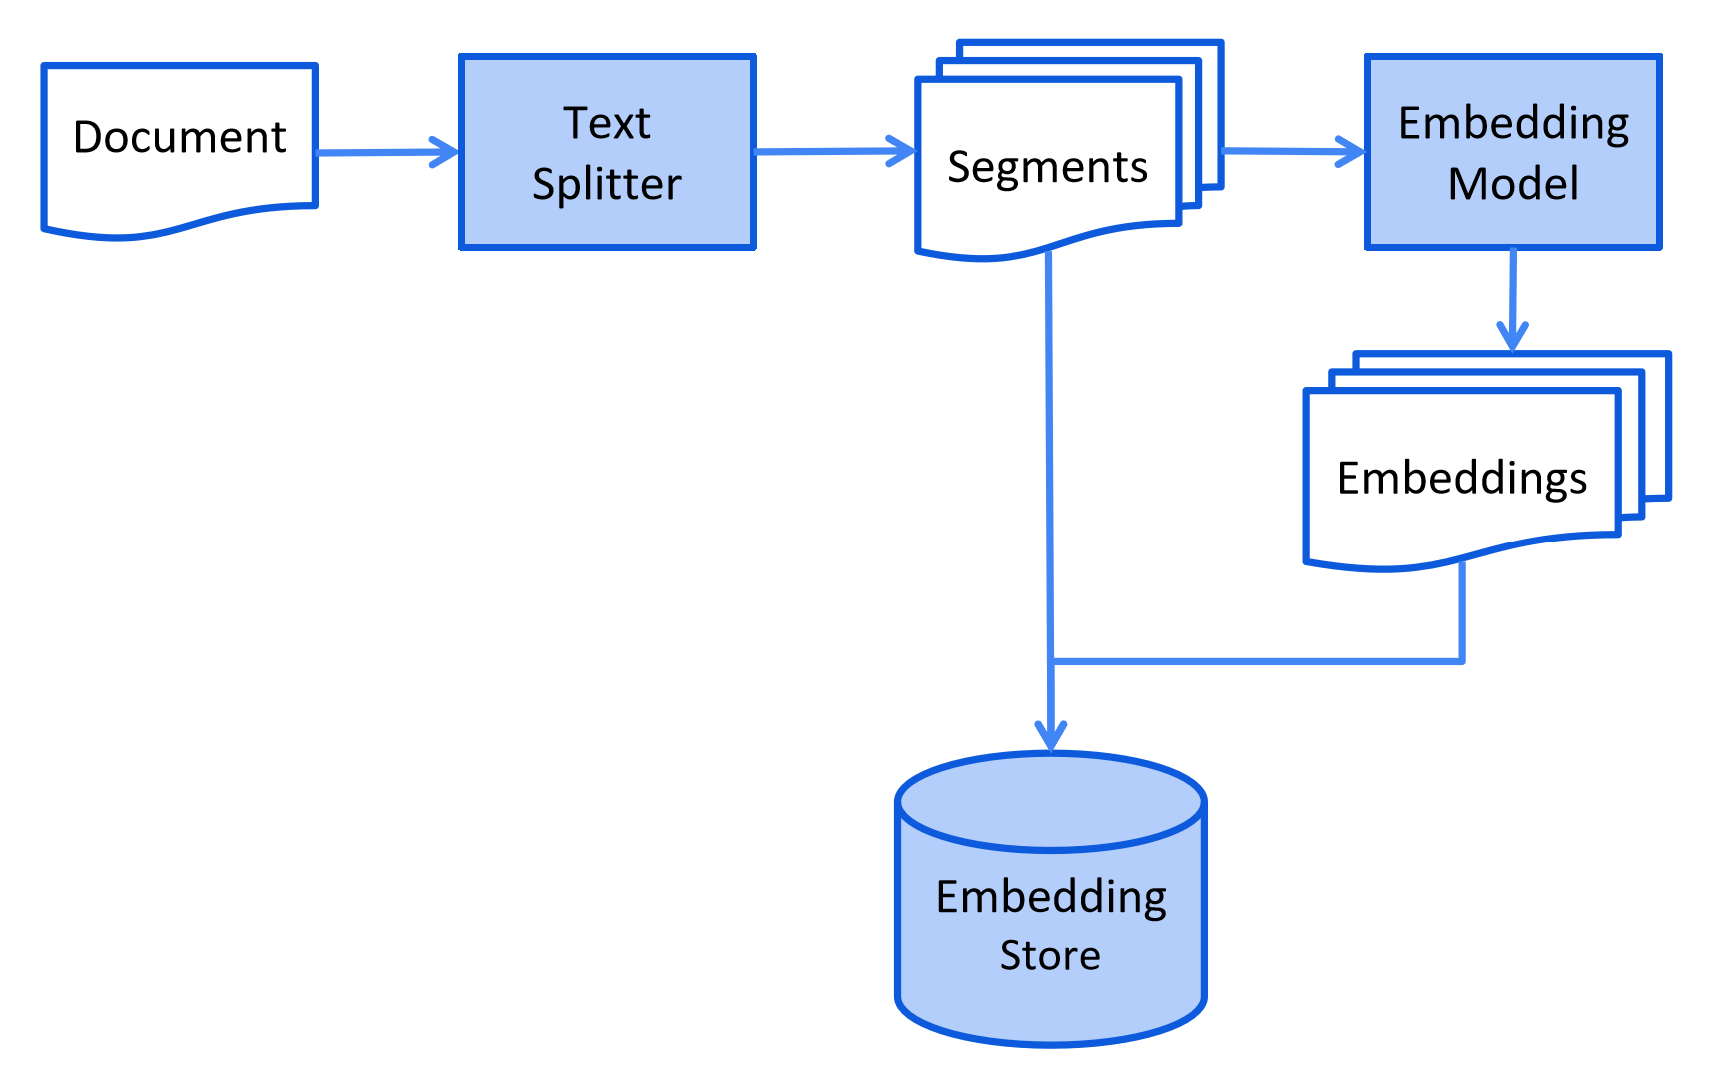

* Retrieving Relevant Documents: For a given query, the most relevant documents are retrieved from the FAISS index.
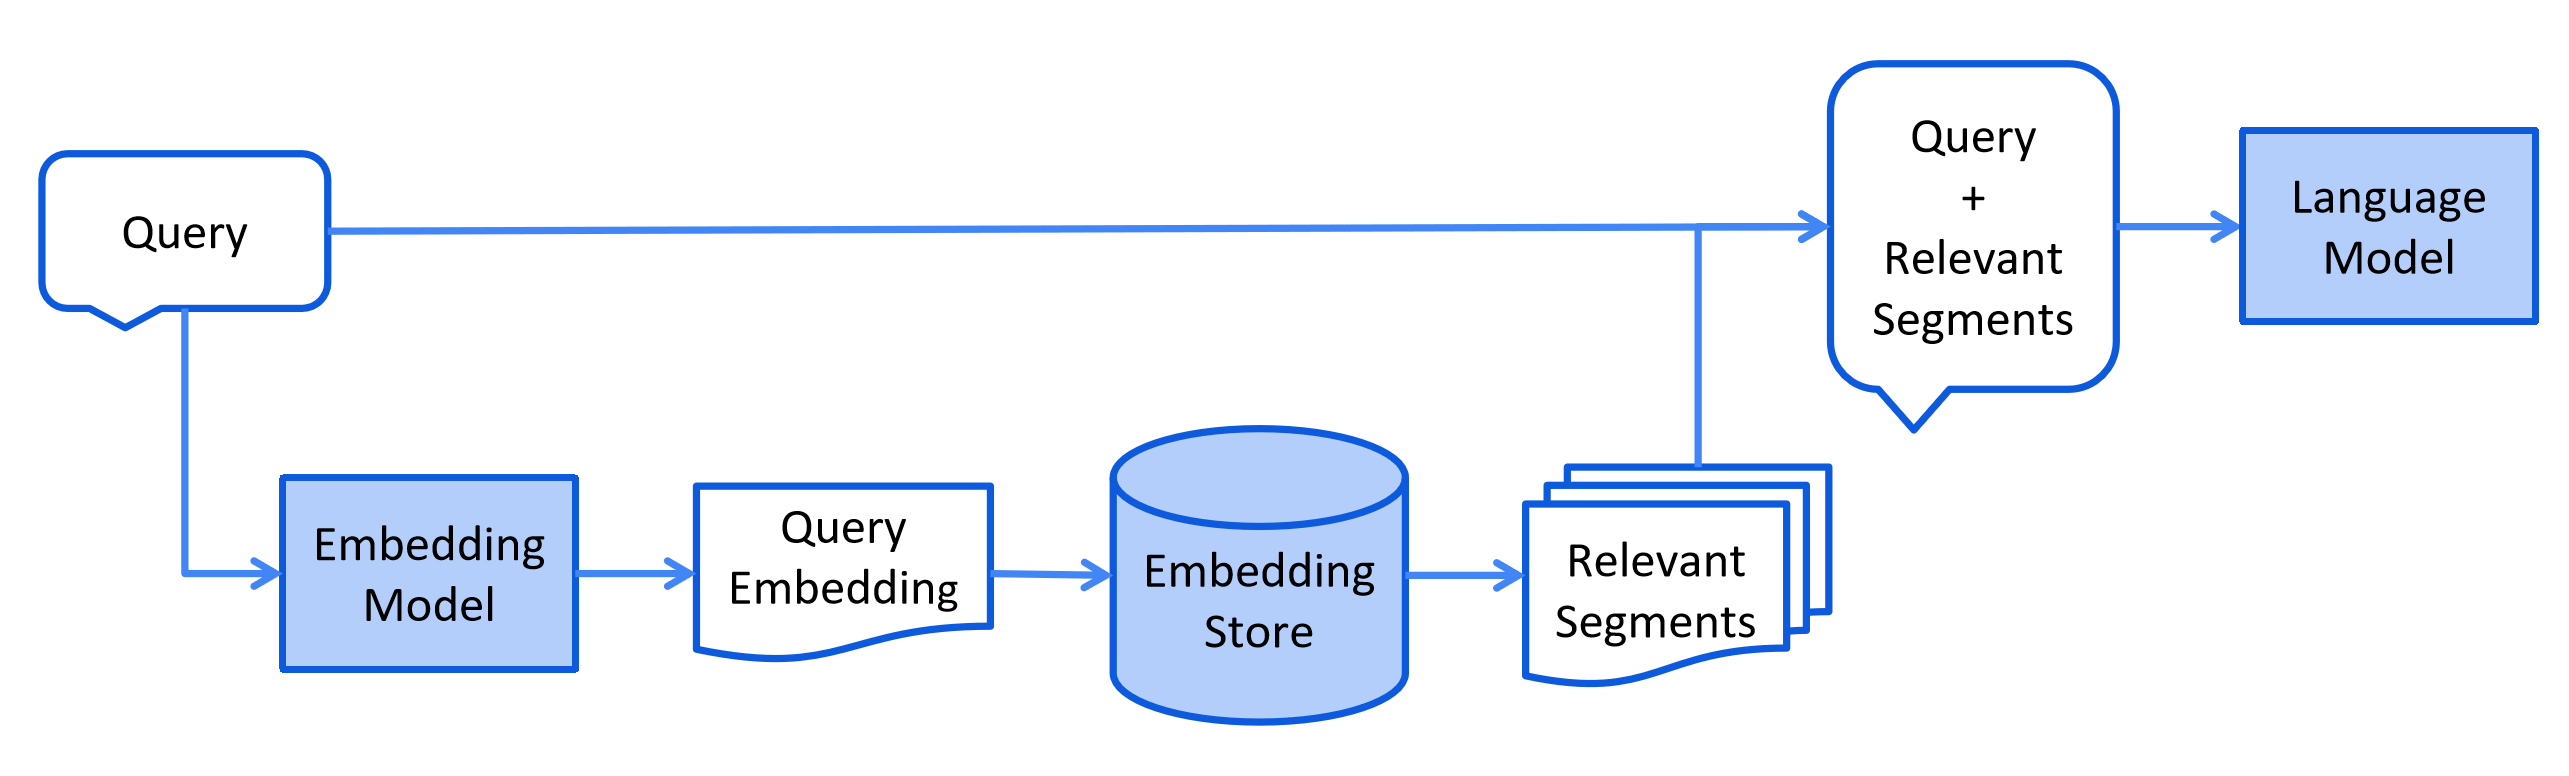
2. Augmented Generation:

* Language Model: A pre-trained language model (e.g., unsloth/llama-3-8b-Instruct-bnb-4bit, Azure/LLAMA3-70B-Instruct) is used for text generation.
* Combining Context: The retrieved documents are used as context to generate more informed and relevant responses to the queries.

3. Reranking (Optional):

* Reranker Model: A reranker model (e.g., colbert-ir/colbertv2.0) is optionally used to further refine the relevance of the retrieved documents before passing them to the language model.


Figures from: https://docs.langchain4j.dev/tutorials/rag/
Reference:https://github.com/huggingface/cookbook/blob/main/notebooks/en

# install dependencies

In [1]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille langchain_huggingface metapub doi2pdf unstructured nltk llama-parse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/647.5 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 614.4/647.5 kB 18.3 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 43.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install doi2pdf

# Import libraries

In [3]:
import nest_asyncio
import asyncio
import os
import textwrap
from pathlib import Path
from IPython.display import Markdown
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import FlashrankRerank
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain.embeddings.fastembed import FastEmbedEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain.vectorstores import FAISS
from llama_parse import LlamaParse
import pandas as pd
from langchain.schema import Document
from datasets import Dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from huggingface_hub import notebook_login
import pacmap
import numpy as np
import plotly.express as px
from ragatouille import RAGPretrainedModel
from transformers import Pipeline
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from tqdm import tqdm

# Apply nest_asyncio for running async code in Jupyter notebooks
nest_asyncio.apply()

# language model (initiate LLM model)


*   Load the LLAMA3 model from Azure ML API endpoint




In [4]:
from langchain_community.chat_models.azureml_endpoint import (
    AzureMLChatOnlineEndpoint,
    AzureMLEndpointApiType,
    CustomOpenAIChatContentFormatter
)
from typing import List, Optional, Tuple

# Define the AzureMLChatOnlineEndpoint
azure_model = AzureMLChatOnlineEndpoint(
    endpoint_url="https://Meta-Llama-3-70B-Instruct-vycmo-serverless.eastus2.inference.ai.azure.com/v1/chat/completions",
    endpoint_api_type=AzureMLEndpointApiType.serverless,
    endpoint_api_key="You Azure model endpoint API key",
    content_formatter=CustomOpenAIChatContentFormatter(),
)

In [5]:
## Check if CUDA (GPU) is available and set the device accordingly
# device = 0 if torch.cuda.is_available() else -1

## Define the Chat Format Prompt:

Create a prompt template for querying using the chat format.

In [6]:

user_query = "What does SELENON-RM stand for?"
# Define the prompt in chat format
system_message = {
    "role": "system",
    "content": """Using the information contained in the context,
    give a comprehensive answer to the question.
    Respond only to the question asked, response should be concise and relevant to the question.
    Provide the number of the source document when relevant.
    If the answer cannot be deduced from the context, do not give an answer."""
}

user_message = {
    "role": "user",
    "content": f"""Now here is the question you need to answer.

    Question: {user_query}"""
}

# Create the final prompt
final_prompt = [system_message, user_message]

## Make an example query with the azure_model

In [7]:

# Define a simple question

# Use the AzureMLChatOnlineEndpoint model to get the response
response = azure_model.invoke(final_prompt)
# Check the response type and print the content
if isinstance(response, (tuple, list)):
    response_message = response[0]
    answer = response_message.content
else:
    answer = response.content

print("Answer:", answer)

Answer: SELENON-RM stands for Selenoprotein N, Related Sequence, RNA-binding motif.


# Data Preparation ( from load data to build Vector Store)

## Load and Preprocess Data:
*   Load data from an Excel file and filter the DataFrame to keep relevant records.

In [9]:
file_path = "all_2023_04_07.xlsx"  # Update with your file path
df = pd.ExcelFile(file_path).parse("all_2023_04_07") # you need to upload the file to the foder shown on the left bar on colab
df=df[df["Labeling_State"]=="Gold Standard"]
df=df[df["Correct_Label"].str.contains("2 - the study's primary" )]

## Convert DataFrame to Dataset and Document List
* Convert the filtered DataFrame to a Dataset object and create a list of Document objects.

In [10]:
# Convert DataFrame to Dataset
dataset_obj = Dataset.from_pandas(df)
knowledge_documents = [
    Document(page_content=doc["ABSTRACT"], metadata={"title": doc["TITLE"], "PMID": doc["PMID"]})
    for doc in dataset_obj
]

## Split Documents into Manageable Chunks

Define a function to split documents into smaller chunks using a tokenizer and text splitting markers.
* TEXT_SPLIT_MARKERS: Defines the markers used to split the text into smaller chunks. These markers represent common structural elements in markdown and plain text documents.

In [11]:
# Constants for text splitting
TEXT_SPLIT_MARKERS = [
    "\n# ", "\n## ", "\n### ", "\n#### ", "\n##### ", "\n###### ",
    "```\n", "\n---\n", "\n***\n", "\n___\n", "\n> ", "\n- ", "\n1. ", "\n\n", "\n", " ", ""
]
EMBEDDING_MODEL_NAME = "thenlper/gte-small"

# Split texts into manageable chunks
def split_documents(max_tokens, documents, tokenizer_model=EMBEDDING_MODEL_NAME):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_model)
    doc_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer,
        chunk_size=max_tokens,
        chunk_overlap=int(max_tokens / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=TEXT_SPLIT_MARKERS,
    )

    split_docs = []
    for document in documents:
        split_docs += doc_splitter.split_documents([document])

    unique_docs = {}
    final_split_docs = []
    for document in split_docs:
        if document.page_content not in unique_docs:
            unique_docs[document.page_content] = True
            final_split_docs.append(document)

    return final_split_docs

# Split documents
processed_docs = split_documents(512, knowledge_documents, tokenizer_model=EMBEDDING_MODEL_NAME)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

## Embedding and Vector Store Creation
* initialize Embedding Model
  

In [12]:
# Initialize embedding model
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},
)


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Create FAISS Vector Store

Create a FAISS vector store from the processed documents using cosine distance strategy.

In [13]:
# Create FAISS vector store
vector_store = FAISS.from_documents(
    processed_docs, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

# Define the RAG LLM Function
* combines RAG and LLM
* the RAG LLM function is to handle query processing, document retrieval,reranking and generating texts for queries.

In [14]:
# Initialize the Reranker
reranker = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

# Define the RAG LLM function with reranker
def rag_llm(question, llm_pipeline, vector_store, reranker, num_retrieved_docs=30, num_docs_final=5):
    # Retrieve documents
    relevant_docs = vector_store.similarity_search(query=question, k=num_retrieved_docs)
    retrieved_docs_text = [doc.page_content for doc in relevant_docs]

    # Rerank documents
    reranked_docs = reranker.rerank(question, retrieved_docs_text)[:num_docs_final]
    reranked_docs_text = [doc["content"] for doc in reranked_docs]

    # Create final prompt using the chat template
    context = "\n\n".join(reranked_docs_text)

    final_prompt_template = [
        {
            "role": "system",
            "content": """You are a medical researcher extracting knowledge
                     assertions from scientific literature.
                     Using the information contained in the context,
            give answer to the question.

          """,
        },
        {
            "role": "user",
            "content": f"""Context:
            {context}
            ---
            Now here is the question you need to answer.

            Question: {question}, retuen the answer as a string. No NEED TO include THE QUESTION AGAIN IN THE ANSWER
            """,
        },
    ]

    # Use the AzureMLChatOnlineEndpoint model to get the response
    print("=> Generating answer...")
    response = azure_model.invoke(final_prompt_template)

    if isinstance(response, (tuple, list)):
        response_message = response[0]  # Adjust based on the actual structure
        answer = response_message.content
    else:
        answer = response.content

    return answer, relevant_docs



artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Example Usage
compare results from LLM with rag and withou RAG

## Test the RAG LLM function with a sample query and print the response

In [15]:
# Another example with a specific question
question = "what is SELENON-RM stahnds for?"
response,ranked_docs = rag_llm(question, azure_model, vector_store,reranker)
print("Response:", response,"\n")

for i,doc in enumerate(ranked_docs):
    print(f'{i}::',doc.page_content,"\n")

100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


=> Generating answer...
Response: SELENON-RM stands for SELENON-related myopathy. 

0:: SELENON (SEPN1)-related myopathy (SELENON-RM) is a rare congenital myopathy characterized by slowly progressive proximal muscle weakness, early onset spine rigidity and respiratory insufficiency. A muscular dystrophy caused by mutations in the LAMA2 gene (LAMA2-related muscular dystrophy, LAMA2-MD) has a similar clinical phenotype, with either a severe, early-onset due to complete Laminin subunit Œ±2 deficiency (merosin-deficient congenital muscular dystrophy type 1A (MDC1A)), or a mild, childhood- or adult-onset due to partial Laminin subunit Œ±2 deficiency. For both muscle diseases, no curative treatment options exist, yet promising preclinical 

1:: to the patient's age and functional abilities. Correlation between key parameters within and between subsequent visits will be assessed. Our study will describe the natural history of patients diagnosed with SELENON-RM or LAMA2-MD, enabling us to sele

## Test the LLM without LAG, and print the response.

In [16]:
# Define a simple question
question = "What does SELENON-RM stand for?"
# Use the AzureMLChatOnlineEndpoint model to get the response
response = azure_model.invoke(final_prompt)
# Check the response type and print the content
if isinstance(response, (tuple, list)):
    response_message = response[0]
    answer = response_message.content
else:
    answer = response.content

print("Answer:", answer)

Answer: SELENON-RM stands for Selenoprotein N, RNA-binding motif.


In [17]:
# # Usage example with the DataFrame
# i=0
# for index, row in df.iterrows():
#     i+=1
#     if i>2:
#         break
#     title = row["TITLE"]
#     abstract = row["ABSTRACT"]
#     question = f"What is the study purpose for the paper titled '{title}'?"
#     response,ranked_docs = rag_llm(question, azure_model, vector_store, reranker)
#     # print(f"ABSTRACT: {abstract}")
#     print(f"Response: {response}","\n")
#     for i,doc in enumerate(ranked_docs):
#       print(f'Document{i}::',doc.page_content,"\n")

#     print("\n")
#     # break  # Remove or adjust this line to process more rows

# Visualization

## Define a function to visualize the query projection among the vector base using PaCMAP.

In [18]:
# Embed the input query and visualize its projection among the vector base using PaCMAP
def visualize_query_projection(query, vector_store, embedding_model, processed_docs):
    # Embed the user query
    embedded_query_vector = embedding_model.embed_query(query)

    # Retrieve embeddings of the documents in the vector store
    high_dim_embeddings = [
        list(vector_store.index.reconstruct_n(idx, 1)[0])
        for idx in range(len(processed_docs))
    ] + [embedded_query_vector]

    high_dim_embeddings_array = np.array(high_dim_embeddings)

    # Initialize PaCMAP for dimensionality reduction
    pacmap_projector = pacmap.PaCMAP(
        n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
    )
    low_dim_embeddings_pacmap = pacmap_projector.fit_transform(high_dim_embeddings_array)

    # Create a DataFrame for visualization
    visualization_df = pd.DataFrame.from_dict(
        [
            {
                "x": low_dim_embeddings_pacmap[i, 0],
                "y": low_dim_embeddings_pacmap[i, 1],
                "PMID": processed_docs[i].metadata["PMID"],
                "extract": processed_docs[i].page_content[:100] + "...",
                "symbol": "circle-open",
                "size_col": 4,
            }
            for i in range(len(processed_docs))
        ]
        + [
            {
                "x": low_dim_embeddings_pacmap[-1, 0],
                "y": low_dim_embeddings_pacmap[-1, 1],
                "PMID": "User query",
                "extract": query,
                "size_col": 80,
                "symbol": "diamond",
            }
        ]
    )

    # Visualize the projection using plotly
    pacmap_figure = px.scatter(
        visualization_df,
        x="x",
        y="y",
        color="PMID",
        hover_data=["extract"],
        size="size_col",
        symbol="symbol",
        color_discrete_map={"User query": "red"},
        width=800,
        height=600,
    )

    # Get the coordinates of the user query for annotation
    query_x_pacmap = low_dim_embeddings_pacmap[-1, 0]
    query_y_pacmap = low_dim_embeddings_pacmap[-1, 1]

    # Add annotation with an arrow pointing to the query
    pacmap_figure.add_annotation(
        x=query_x_pacmap,
        y=query_y_pacmap,
        xref="x",
        yref="y",
        text="Query",
        showarrow=True,
        arrowhead=5,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="black",
        ax=-60,
        ay=-60,
        font=dict(color="black", size=18),
    )

    pacmap_figure.update_layout(
        showlegend=False,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        xaxis=dict(title='PaCMAP1', showline=True, linewidth=2, linecolor='black', mirror=True),
        yaxis=dict(title='PaCMAP2', showline=True, linewidth=2, linecolor='black', mirror=True),
        legend_title_text="<b>Chunk PMID</b>",
        title="<b>2D Visualization of Document Embeddings Using PaCMAP</b>",
    )

    pacmap_figure.show()

## Run an example query in a datafram and project to 2D for visualization

In [19]:
# Usage example with the DataFrame
i=0
for index, row in df.iterrows():
    i+=1
    if i>2:
        break
    title = row["TITLE"]
    abstract = row["ABSTRACT"]
    question = f"What is the study purpose for the paper titled '{title}'?"
    response,ranked_docs = rag_llm(question, azure_model, vector_store, reranker)
    # print(f"ABSTRACT: {abstract}")
    print(f"Response: {response}","\n")
    for i,doc in enumerate(ranked_docs):
      print(f'Document{i}::',doc.page_content,"\n")

    # Visualize the query projection
    visualize_query_projection(question, vector_store, embedding_model, processed_docs)
    print("\n")

    # break  # Remove or adjust this line to process more rows

100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


=> Generating answer...
Response: "We describe a large pediatric PSC cohort with longitudinal follow-up." 

Document0:: Data regarding pediatric primary sclerosing cholangitis (PSC) natural history are limited. We describe a large pediatric PSC cohort with longitudinal follow-up. The present study records review of pediatric patients with PSC diagnosed between 1984 and 2014. N‚Ää=‚Ää120 (63% M) ages 1 to 21 years (median 14 years) at diagnosis. 27% (31/113) had autoimmune sclerosing cholangitis (ASC), 24% had exclusive small duct PSC, METAVIR stage was F3-F4 in 41%. Eighty-one percent of patients with PSC had inflammatory bowel disease (IBD); most had ulcerative/indeterminate colitis (72/97), typically pancolitis 

Document1:: Primary sclerosing cholangitis (PSC) is a rare obliterative fibrotic condition of the bile ducts. We assessed PSC epidemiology and natural history within the UK Clinical Practice Research Datalink (CPRD).Incidence and natural history of PSC were evaluated in a re

/usr/local/lib/python3.10/dist-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [20]:
# # Another example with a specific question
# question = "What is CSF?"
# response, reranked_docs = rag_llm(question, azure_model, vector_store, reranker)
# print("Response:", response)
# visualize_query_projection(question, vector_store, embedding_model, processed_docs)

# Run Golden Standard data, query with the RAG-LLM model

In [21]:
questions_list = [
    "study purpose",
    "type of study",
    "duration of the study",
    "participants bumbers in study",
    "data collection occur",
    "inclusion criteria for the study",
    "exclusion criteria for the study",
    "clinical outcomes",
    "differed between the treatments",
    "rare disease associated with the study"
]

In [22]:
df_temp = df.copy()

In [24]:
# from tqdm import tqdm
# import time

# # Define the starting points
# start_row = 77
# start_question = 5

# # Initialize the row counter
# i = 0

# # Iterate over the rows in the DataFrame
# for index, row in tqdm(df_temp.iterrows(), total=df_temp.shape[0], desc="Processing rows"):
#     i += 1
#     if i < start_row:
#         continue  # Skip rows until reaching the start_row

#     # Initialize the question counter
#     j = 0

#     # Iterate over the questions list
#     for question_index, question in enumerate(tqdm(questions_list, total=len(questions_list), desc=f"Processing questions for row {i}")):
#         j += 1
#         if i == start_row and question_index < (start_question - 1):
#             continue  # Skip questions until reaching the start_question

#         print(f"\nProcessing row {i} question {j}:: {question}\n")

#         # Extract necessary information from the row
#         title = row["TITLE"]
#         PMID = row["PMID"]
#         question1 = question + f" for paper with title {title}."

#         # Call the rag_llm function
#         answer, relevant_docs = rag_llm(question1, azure_model, vector_store, reranker)

#         # Store the answer in the DataFrame
#         df_temp.loc[index, question] = answer

#         # Sleep to avoid API rate limits
#         time.sleep(1)


## Process the DataFrame and mark timeout cells

In [ ]:
from tqdm import tqdm
import time

# Define the starting points
start_row = 1
start_question = 1

# Initialize the row counter
i = 0

# Function to handle the rag_llm call with retries
def rag_llm_with_retry(question, azure_model, vector_store, reranker, retries=3, sleep_time=1):
    while retries > 0:
        try:
            answer, relevant_docs = rag_llm(question, azure_model, vector_store, reranker)
            return answer, relevant_docs
        except TimeoutError as e:
            retries -= 1
            if retries <= 0:
                return "timeout error", None
            else:
                print(f"Retrying... {retries} attempts left")
                time.sleep(sleep_time)

# Step 1: Process the DataFrame and mark errors
for index, row in tqdm(df_temp.iterrows(), total=df_temp.shape[0], desc="Processing rows"):
    i += 1
    if i < start_row:
        continue  # Skip rows until reaching the start_row

    # Initialize the question counter
    j = 0

    # Iterate over the questions list
    for question_index, question in enumerate(tqdm(questions_list, total=len(questions_list), desc=f"Processing questions for row {i}")):
        j += 1
        if i == start_row and question_index < (start_question - 1):
            continue  # Skip questions until reaching the start_question

        print(f"\nProcessing row {i} question {j}:: {question}\n")

        # Extract necessary information from the row
        title = row["TITLE"]
        PMID = row["PMID"]
        question1 = question + f" for paper with title {title}."

        # Call the rag_llm function with retry mechanism
        answer, relevant_docs = rag_llm_with_retry(question1, azure_model, vector_store, reranker)

        # Store the answer or error message in the DataFrame
        df_temp.loc[index, question] = answer

        # Sleep to avoid API rate limits
        time.sleep(1)


Processing questions for row 1:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 1 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


=> Generating answer...



Processing questions for row 1:  10%|█         | 1/10 [00:07<01:06,  7.40s/it]


Processing row 1 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


=> Generating answer...



Processing questions for row 1:  20%|██        | 2/10 [00:13<00:54,  6.77s/it]


Processing row 1 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


=> Generating answer...



Processing questions for row 1:  30%|███       | 3/10 [00:24<01:01,  8.77s/it]


Processing row 1 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


=> Generating answer...



Processing questions for row 1:  40%|████      | 4/10 [00:31<00:47,  7.85s/it]


Processing row 1 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


=> Generating answer...



Processing questions for row 1:  50%|█████     | 5/10 [00:37<00:37,  7.40s/it]


Processing row 1 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


=> Generating answer...



Processing questions for row 1:  60%|██████    | 6/10 [00:49<00:34,  8.72s/it]


Processing row 1 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


=> Generating answer...



Processing questions for row 1:  70%|███████   | 7/10 [01:04<00:32, 10.82s/it]


Processing row 1 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


=> Generating answer...



Processing questions for row 1:  80%|████████  | 8/10 [01:24<00:27, 13.74s/it]


Processing row 1 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


=> Generating answer...



Processing questions for row 1:  90%|█████████ | 9/10 [01:35<00:13, 13.05s/it]


Processing row 1 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


=> Generating answer...



Processing questions for row 2:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 2 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


=> Generating answer...



Processing questions for row 2:  10%|█         | 1/10 [00:51<07:44, 51.66s/it]


Processing row 2 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


=> Generating answer...



Processing questions for row 2:  20%|██        | 2/10 [00:58<03:21, 25.21s/it]


Processing row 2 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


=> Generating answer...



Processing questions for row 2:  30%|███       | 3/10 [01:26<03:06, 26.68s/it]


Processing row 2 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


=> Generating answer...



Processing questions for row 2:  40%|████      | 4/10 [01:56<02:47, 27.87s/it]


Processing row 2 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


=> Generating answer...



Processing questions for row 2:  50%|█████     | 5/10 [02:06<01:47, 21.58s/it]


Processing row 2 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


=> Generating answer...



Processing questions for row 2:  60%|██████    | 6/10 [02:14<01:07, 16.94s/it]


Processing row 2 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


=> Generating answer...



Processing questions for row 2:  70%|███████   | 7/10 [02:21<00:41, 13.67s/it]


Processing row 2 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


=> Generating answer...



Processing questions for row 2:  80%|████████  | 8/10 [02:37<00:28, 14.18s/it]


Processing row 2 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


=> Generating answer...



Processing questions for row 2:  90%|█████████ | 9/10 [02:47<00:13, 13.02s/it]


Processing row 2 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


=> Generating answer...



Processing questions for row 3:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 3 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


=> Generating answer...



Processing questions for row 3:  10%|█         | 1/10 [00:12<01:50, 12.25s/it]


Processing row 3 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


=> Generating answer...



Processing questions for row 3:  20%|██        | 2/10 [00:18<01:09,  8.67s/it]


Processing row 3 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


=> Generating answer...



Processing questions for row 3:  30%|███       | 3/10 [00:47<02:07, 18.19s/it]


Processing row 3 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


=> Generating answer...



Processing questions for row 3:  40%|████      | 4/10 [00:56<01:25, 14.29s/it]


Processing row 3 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


=> Generating answer...



Processing questions for row 3:  50%|█████     | 5/10 [01:03<00:59, 11.89s/it]


Processing row 3 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


=> Generating answer...



Processing questions for row 3:  60%|██████    | 6/10 [01:12<00:42, 10.67s/it]


Processing row 3 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


=> Generating answer...



Processing questions for row 3:  70%|███████   | 7/10 [01:19<00:28,  9.54s/it]


Processing row 3 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


=> Generating answer...



Processing questions for row 3:  80%|████████  | 8/10 [01:34<00:22, 11.27s/it]


Processing row 3 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


=> Generating answer...



Processing questions for row 3:  90%|█████████ | 9/10 [02:28<00:24, 24.76s/it]


Processing row 3 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


=> Generating answer...



Processing questions for row 4:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 4 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


=> Generating answer...



Processing questions for row 4:  10%|█         | 1/10 [00:08<01:17,  8.61s/it]


Processing row 4 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


=> Generating answer...



Processing questions for row 4:  20%|██        | 2/10 [00:15<00:59,  7.39s/it]


Processing row 4 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


=> Generating answer...



Processing questions for row 4:  30%|███       | 3/10 [00:21<00:48,  6.89s/it]


Processing row 4 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


=> Generating answer...



Processing questions for row 4:  40%|████      | 4/10 [00:27<00:39,  6.58s/it]


Processing row 4 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


=> Generating answer...



Processing questions for row 4:  50%|█████     | 5/10 [00:35<00:35,  7.12s/it]


Processing row 4 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


=> Generating answer...



Processing questions for row 4:  60%|██████    | 6/10 [00:44<00:30,  7.62s/it]


Processing row 4 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


=> Generating answer...



Processing questions for row 4:  70%|███████   | 7/10 [00:54<00:25,  8.63s/it]


Processing row 4 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


=> Generating answer...



Processing questions for row 4:  80%|████████  | 8/10 [01:04<00:18,  9.06s/it]


Processing row 4 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


=> Generating answer...



Processing questions for row 4:  90%|█████████ | 9/10 [01:12<00:08,  8.68s/it]


Processing row 4 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


=> Generating answer...



Processing questions for row 5:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 5 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


=> Generating answer...



Processing questions for row 5:  10%|█         | 1/10 [00:07<01:11,  7.94s/it]


Processing row 5 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


=> Generating answer...



Processing questions for row 5:  20%|██        | 2/10 [00:14<00:56,  7.01s/it]


Processing row 5 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


=> Generating answer...



Processing questions for row 5:  30%|███       | 3/10 [00:21<00:48,  6.99s/it]


Processing row 5 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


=> Generating answer...



Processing questions for row 5:  40%|████      | 4/10 [00:27<00:40,  6.80s/it]


Processing row 5 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


=> Generating answer...



Processing questions for row 5:  50%|█████     | 5/10 [00:34<00:33,  6.78s/it]


Processing row 5 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


=> Generating answer...



Processing questions for row 5:  60%|██████    | 6/10 [00:43<00:30,  7.52s/it]


Processing row 5 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


=> Generating answer...



Processing questions for row 5:  70%|███████   | 7/10 [00:50<00:22,  7.42s/it]


Processing row 5 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


=> Generating answer...



Processing questions for row 5:  80%|████████  | 8/10 [00:59<00:15,  7.98s/it]


Processing row 5 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


=> Generating answer...



Processing questions for row 5:  90%|█████████ | 9/10 [01:09<00:08,  8.45s/it]


Processing row 5 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


=> Generating answer...



Processing questions for row 6:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 6 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


=> Generating answer...



Processing questions for row 6:  10%|█         | 1/10 [00:06<00:59,  6.62s/it]


Processing row 6 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


=> Generating answer...



Processing questions for row 6:  20%|██        | 2/10 [00:13<00:51,  6.48s/it]


Processing row 6 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


=> Generating answer...



Processing questions for row 6:  30%|███       | 3/10 [00:20<00:47,  6.76s/it]


Processing row 6 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


=> Generating answer...



Processing questions for row 6:  40%|████      | 4/10 [00:26<00:39,  6.58s/it]


Processing row 6 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


=> Generating answer...



Processing questions for row 6:  50%|█████     | 5/10 [00:33<00:33,  6.76s/it]


Processing row 6 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


=> Generating answer...



Processing questions for row 6:  60%|██████    | 6/10 [00:40<00:27,  6.91s/it]


Processing row 6 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


=> Generating answer...



Processing questions for row 6:  70%|███████   | 7/10 [00:47<00:20,  6.88s/it]


Processing row 6 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


=> Generating answer...



Processing questions for row 6:  80%|████████  | 8/10 [00:57<00:15,  7.91s/it]


Processing row 6 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


=> Generating answer...



Processing questions for row 6:  90%|█████████ | 9/10 [01:05<00:08,  8.03s/it]


Processing row 6 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


=> Generating answer...



Processing questions for row 7:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 7 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


=> Generating answer...



Processing questions for row 7:  10%|█         | 1/10 [00:08<01:17,  8.62s/it]


Processing row 7 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


=> Generating answer...



Processing questions for row 7:  20%|██        | 2/10 [00:15<00:59,  7.40s/it]


Processing row 7 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


=> Generating answer...



Processing questions for row 7:  30%|███       | 3/10 [00:22<00:53,  7.58s/it]


Processing row 7 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


=> Generating answer...



Processing questions for row 7:  40%|████      | 4/10 [00:30<00:44,  7.39s/it]


Processing row 7 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


=> Generating answer...



Processing questions for row 7:  50%|█████     | 5/10 [00:39<00:40,  8.10s/it]


Processing row 7 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


=> Generating answer...



Processing questions for row 7:  60%|██████    | 6/10 [00:47<00:31,  7.97s/it]


Processing row 7 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


=> Generating answer...



Processing questions for row 7:  70%|███████   | 7/10 [00:54<00:23,  7.68s/it]


Processing row 7 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


=> Generating answer...



Processing questions for row 7:  80%|████████  | 8/10 [01:02<00:15,  7.71s/it]


Processing row 7 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


=> Generating answer...



Processing questions for row 7:  90%|█████████ | 9/10 [01:14<00:09,  9.28s/it]


Processing row 7 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


=> Generating answer...



Processing questions for row 8:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 8 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


=> Generating answer...



Processing questions for row 8:  10%|█         | 1/10 [00:07<01:11,  7.99s/it]


Processing row 8 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


=> Generating answer...



Processing questions for row 8:  20%|██        | 2/10 [00:14<00:58,  7.30s/it]


Processing row 8 question 3:: duration of the study





100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


=> Generating answer...



Processing questions for row 8:  30%|███       | 3/10 [00:27<01:07,  9.61s/it]


Processing row 8 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


=> Generating answer...



Processing questions for row 8:  40%|████      | 4/10 [00:33<00:50,  8.37s/it]


Processing row 8 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


=> Generating answer...



Processing questions for row 8:  50%|█████     | 5/10 [00:42<00:42,  8.43s/it]


Processing row 8 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


=> Generating answer...



Processing questions for row 8:  60%|██████    | 6/10 [00:52<00:36,  9.00s/it]


Processing row 8 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


=> Generating answer...



Processing questions for row 8:  70%|███████   | 7/10 [01:04<00:29,  9.91s/it]


Processing row 8 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


=> Generating answer...



Processing questions for row 8:  80%|████████  | 8/10 [01:11<00:18,  9.23s/it]


Processing row 8 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


=> Generating answer...



Processing questions for row 8:  90%|█████████ | 9/10 [01:27<00:11, 11.36s/it]


Processing row 8 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


=> Generating answer...



Processing questions for row 9:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 9 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


=> Generating answer...



Processing questions for row 9:  10%|█         | 1/10 [00:08<01:15,  8.34s/it]


Processing row 9 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


=> Generating answer...



Processing questions for row 9:  20%|██        | 2/10 [00:14<00:58,  7.29s/it]


Processing row 9 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


=> Generating answer...



Processing questions for row 9:  30%|███       | 3/10 [00:21<00:49,  7.05s/it]


Processing row 9 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


=> Generating answer...



Processing questions for row 9:  40%|████      | 4/10 [00:27<00:40,  6.73s/it]


Processing row 9 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


=> Generating answer...



Processing questions for row 9:  50%|█████     | 5/10 [00:44<00:52, 10.45s/it]


Processing row 9 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


=> Generating answer...



Processing questions for row 9:  60%|██████    | 6/10 [01:10<01:02, 15.55s/it]


Processing row 9 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


=> Generating answer...



Processing questions for row 9:  70%|███████   | 7/10 [01:17<00:38, 12.94s/it]


Processing row 9 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


=> Generating answer...



Processing questions for row 9:  80%|████████  | 8/10 [01:28<00:24, 12.17s/it]


Processing row 9 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


=> Generating answer...
Retrying... 2 attempts left




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


=> Generating answer...



Processing questions for row 9:  90%|█████████ | 9/10 [02:52<00:34, 34.67s/it]


Processing row 9 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


=> Generating answer...



Processing questions for row 10:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 10 question 1:: study purpose





100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


=> Generating answer...



Processing questions for row 10:  10%|█         | 1/10 [00:31<04:43, 31.46s/it]


Processing row 10 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


=> Generating answer...



Processing questions for row 10:  20%|██        | 2/10 [00:52<03:21, 25.14s/it]


Processing row 10 question 3:: duration of the study





100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


=> Generating answer...



Processing questions for row 10:  30%|███       | 3/10 [00:58<01:57, 16.77s/it]


Processing row 10 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


=> Generating answer...



Processing questions for row 10:  40%|████      | 4/10 [01:07<01:20, 13.46s/it]


Processing row 10 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


=> Generating answer...



Processing questions for row 10:  50%|█████     | 5/10 [01:14<00:55, 11.06s/it]


Processing row 10 question 6:: inclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


=> Generating answer...



Processing questions for row 10:  60%|██████    | 6/10 [01:23<00:42, 10.60s/it]


Processing row 10 question 7:: exclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


=> Generating answer...



Processing questions for row 10:  70%|███████   | 7/10 [01:31<00:28,  9.50s/it]


Processing row 10 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


=> Generating answer...



Processing questions for row 10:  80%|████████  | 8/10 [01:42<00:20, 10.12s/it]


Processing row 10 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


=> Generating answer...



Processing questions for row 10:  90%|█████████ | 9/10 [01:53<00:10, 10.40s/it]


Processing row 10 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


=> Generating answer...



Processing questions for row 11:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 11 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


=> Generating answer...



Processing questions for row 11:  10%|█         | 1/10 [00:07<01:03,  7.09s/it]


Processing row 11 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.77it/s]


=> Generating answer...



Processing questions for row 11:  20%|██        | 2/10 [00:13<00:55,  6.90s/it]


Processing row 11 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


=> Generating answer...



Processing questions for row 11:  30%|███       | 3/10 [00:20<00:47,  6.81s/it]


Processing row 11 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


=> Generating answer...



Processing questions for row 11:  40%|████      | 4/10 [00:30<00:47,  7.90s/it]


Processing row 11 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


=> Generating answer...



Processing questions for row 11:  50%|█████     | 5/10 [00:36<00:37,  7.44s/it]


Processing row 11 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


=> Generating answer...



Processing questions for row 11:  60%|██████    | 6/10 [00:44<00:30,  7.69s/it]


Processing row 11 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


=> Generating answer...



Processing questions for row 11:  70%|███████   | 7/10 [00:54<00:25,  8.43s/it]


Processing row 11 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


=> Generating answer...



Processing questions for row 11:  80%|████████  | 8/10 [01:06<00:18,  9.46s/it]


Processing row 11 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


=> Generating answer...



Processing questions for row 11:  90%|█████████ | 9/10 [01:14<00:08,  8.85s/it]


Processing row 11 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


=> Generating answer...



Processing questions for row 12:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 12 question 1:: study purpose





100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


=> Generating answer...



Processing questions for row 12:  10%|█         | 1/10 [00:10<01:34, 10.53s/it]


Processing row 12 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


=> Generating answer...



Processing questions for row 12:  20%|██        | 2/10 [00:16<01:03,  7.94s/it]


Processing row 12 question 3:: duration of the study





100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


=> Generating answer...



Processing questions for row 12:  30%|███       | 3/10 [00:22<00:50,  7.17s/it]


Processing row 12 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


=> Generating answer...



Processing questions for row 12:  40%|████      | 4/10 [00:46<01:22, 13.73s/it]


Processing row 12 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


=> Generating answer...



Processing questions for row 12:  50%|█████     | 5/10 [00:53<00:55, 11.19s/it]


Processing row 12 question 6:: inclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


=> Generating answer...



Processing questions for row 12:  60%|██████    | 6/10 [01:01<00:41, 10.26s/it]


Processing row 12 question 7:: exclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


=> Generating answer...



Processing questions for row 12:  70%|███████   | 7/10 [01:08<00:27,  9.18s/it]


Processing row 12 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


=> Generating answer...



Processing questions for row 12:  80%|████████  | 8/10 [01:15<00:16,  8.45s/it]


Processing row 12 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


=> Generating answer...



Processing questions for row 12:  90%|█████████ | 9/10 [01:22<00:07,  7.86s/it]


Processing row 12 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


=> Generating answer...



Processing questions for row 13:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 13 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


=> Generating answer...



Processing questions for row 13:  10%|█         | 1/10 [00:07<01:09,  7.72s/it]


Processing row 13 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


=> Generating answer...



Processing questions for row 13:  20%|██        | 2/10 [00:13<00:53,  6.70s/it]


Processing row 13 question 3:: duration of the study





100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


=> Generating answer...



Processing questions for row 13:  30%|███       | 3/10 [00:20<00:45,  6.53s/it]


Processing row 13 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


=> Generating answer...



Processing questions for row 13:  40%|████      | 4/10 [00:32<00:52,  8.69s/it]


Processing row 13 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


=> Generating answer...



Processing questions for row 13:  50%|█████     | 5/10 [00:38<00:40,  8.00s/it]


Processing row 13 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


=> Generating answer...



Processing questions for row 13:  60%|██████    | 6/10 [00:46<00:31,  7.84s/it]


Processing row 13 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


=> Generating answer...



Processing questions for row 13:  70%|███████   | 7/10 [00:53<00:22,  7.52s/it]


Processing row 13 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


=> Generating answer...



Processing questions for row 13:  80%|████████  | 8/10 [01:00<00:15,  7.55s/it]


Processing row 13 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


=> Generating answer...



Processing questions for row 13:  90%|█████████ | 9/10 [01:08<00:07,  7.68s/it]


Processing row 13 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


=> Generating answer...



Processing questions for row 14:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 14 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


=> Generating answer...



Processing questions for row 14:  10%|█         | 1/10 [00:07<01:05,  7.33s/it]


Processing row 14 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


=> Generating answer...



Processing questions for row 14:  20%|██        | 2/10 [00:13<00:53,  6.66s/it]


Processing row 14 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


=> Generating answer...



Processing questions for row 14:  30%|███       | 3/10 [00:19<00:45,  6.55s/it]


Processing row 14 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


=> Generating answer...



Processing questions for row 14:  40%|████      | 4/10 [00:32<00:54,  9.03s/it]


Processing row 14 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


=> Generating answer...



Processing questions for row 14:  50%|█████     | 5/10 [00:42<00:46,  9.38s/it]


Processing row 14 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


=> Generating answer...



Processing questions for row 14:  60%|██████    | 6/10 [00:50<00:34,  8.70s/it]


Processing row 14 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


=> Generating answer...



Processing questions for row 14:  70%|███████   | 7/10 [00:58<00:25,  8.66s/it]


Processing row 14 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


=> Generating answer...



Processing questions for row 14:  80%|████████  | 8/10 [01:08<00:18,  9.11s/it]


Processing row 14 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


=> Generating answer...



Processing questions for row 14:  90%|█████████ | 9/10 [01:17<00:08,  8.87s/it]


Processing row 14 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


=> Generating answer...



Processing questions for row 15:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 15 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


=> Generating answer...



Processing questions for row 15:  10%|█         | 1/10 [00:09<01:24,  9.41s/it]


Processing row 15 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


=> Generating answer...



Processing questions for row 15:  20%|██        | 2/10 [00:16<01:05,  8.25s/it]


Processing row 15 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


=> Generating answer...



Processing questions for row 15:  30%|███       | 3/10 [00:23<00:53,  7.59s/it]


Processing row 15 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


=> Generating answer...



Processing questions for row 15:  40%|████      | 4/10 [00:50<01:32, 15.38s/it]


Processing row 15 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


=> Generating answer...



Processing questions for row 15:  50%|█████     | 5/10 [01:25<01:52, 22.44s/it]


Processing row 15 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


=> Generating answer...



Processing questions for row 15:  60%|██████    | 6/10 [01:35<01:12, 18.05s/it]


Processing row 15 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


=> Generating answer...



Processing questions for row 15:  70%|███████   | 7/10 [01:44<00:44, 14.99s/it]


Processing row 15 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


=> Generating answer...



Processing questions for row 15:  80%|████████  | 8/10 [01:54<00:27, 13.65s/it]


Processing row 15 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


=> Generating answer...



Processing questions for row 15:  90%|█████████ | 9/10 [02:02<00:11, 11.62s/it]


Processing row 15 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


=> Generating answer...



Processing questions for row 16:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 16 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


=> Generating answer...



Processing questions for row 16:  10%|█         | 1/10 [00:15<02:18, 15.39s/it]


Processing row 16 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


=> Generating answer...



Processing questions for row 16:  20%|██        | 2/10 [00:33<02:17, 17.23s/it]


Processing row 16 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


=> Generating answer...



Processing questions for row 16:  30%|███       | 3/10 [00:44<01:40, 14.30s/it]


Processing row 16 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


=> Generating answer...



Processing questions for row 16:  40%|████      | 4/10 [01:09<01:50, 18.45s/it]


Processing row 16 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


=> Generating answer...



Processing questions for row 16:  50%|█████     | 5/10 [01:24<01:25, 17.07s/it]


Processing row 16 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


=> Generating answer...



Processing questions for row 16:  60%|██████    | 6/10 [01:41<01:08, 17.24s/it]


Processing row 16 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


=> Generating answer...



Processing questions for row 16:  70%|███████   | 7/10 [01:50<00:43, 14.57s/it]


Processing row 16 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


=> Generating answer...



Processing questions for row 16:  80%|████████  | 8/10 [02:00<00:25, 12.91s/it]


Processing row 16 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


=> Generating answer...



Processing questions for row 16:  90%|█████████ | 9/10 [02:19<00:14, 14.99s/it]


Processing row 16 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


=> Generating answer...



Processing questions for row 17:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 17 question 1:: study purpose





100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


=> Generating answer...



Processing questions for row 17:  10%|█         | 1/10 [00:07<01:11,  7.95s/it]


Processing row 17 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


=> Generating answer...



Processing questions for row 17:  20%|██        | 2/10 [00:14<00:56,  7.11s/it]


Processing row 17 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


=> Generating answer...



Processing questions for row 17:  30%|███       | 3/10 [00:21<00:50,  7.15s/it]


Processing row 17 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


=> Generating answer...



Processing questions for row 17:  40%|████      | 4/10 [00:58<01:53, 18.84s/it]


Processing row 17 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


=> Generating answer...



Processing questions for row 17:  50%|█████     | 5/10 [01:10<01:22, 16.55s/it]


Processing row 17 question 6:: inclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


=> Generating answer...



Processing questions for row 17:  60%|██████    | 6/10 [01:19<00:55, 13.78s/it]


Processing row 17 question 7:: exclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


=> Generating answer...



Processing questions for row 17:  70%|███████   | 7/10 [01:28<00:37, 12.42s/it]


Processing row 17 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


=> Generating answer...



Processing questions for row 17:  80%|████████  | 8/10 [01:42<00:25, 12.91s/it]


Processing row 17 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


=> Generating answer...



Processing questions for row 17:  90%|█████████ | 9/10 [01:52<00:11, 11.72s/it]


Processing row 17 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


=> Generating answer...



Processing questions for row 18:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 18 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


=> Generating answer...



Processing questions for row 18:  10%|█         | 1/10 [00:15<02:15, 15.08s/it]


Processing row 18 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


=> Generating answer...



Processing questions for row 18:  20%|██        | 2/10 [00:21<01:20, 10.05s/it]


Processing row 18 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


=> Generating answer...



Processing questions for row 18:  30%|███       | 3/10 [00:27<00:58,  8.34s/it]


Processing row 18 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


=> Generating answer...



Processing questions for row 18:  40%|████      | 4/10 [00:34<00:45,  7.60s/it]


Processing row 18 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


=> Generating answer...



Processing questions for row 18:  50%|█████     | 5/10 [00:40<00:36,  7.24s/it]


Processing row 18 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


=> Generating answer...



Processing questions for row 18:  60%|██████    | 6/10 [00:49<00:30,  7.65s/it]


Processing row 18 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


=> Generating answer...



Processing questions for row 18:  70%|███████   | 7/10 [00:56<00:21,  7.31s/it]


Processing row 18 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


=> Generating answer...



Processing questions for row 18:  80%|████████  | 8/10 [01:04<00:15,  7.57s/it]


Processing row 18 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


=> Generating answer...



Processing questions for row 18:  90%|█████████ | 9/10 [01:11<00:07,  7.38s/it]


Processing row 18 question 10:: rare disease associated with the study





100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


=> Generating answer...



Processing questions for row 19:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 19 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


=> Generating answer...



Processing questions for row 19:  10%|█         | 1/10 [00:09<01:24,  9.40s/it]


Processing row 19 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


=> Generating answer...



Processing questions for row 19:  20%|██        | 2/10 [00:16<01:02,  7.78s/it]


Processing row 19 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


=> Generating answer...



Processing questions for row 19:  30%|███       | 3/10 [00:23<00:52,  7.54s/it]


Processing row 19 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


=> Generating answer...



Processing questions for row 19:  40%|████      | 4/10 [00:29<00:42,  7.08s/it]


Processing row 19 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


=> Generating answer...



Processing questions for row 19:  50%|█████     | 5/10 [00:37<00:36,  7.40s/it]


Processing row 19 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


=> Generating answer...



Processing questions for row 19:  60%|██████    | 6/10 [00:45<00:30,  7.53s/it]


Processing row 19 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


=> Generating answer...



Processing questions for row 19:  70%|███████   | 7/10 [00:56<00:25,  8.62s/it]


Processing row 19 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


=> Generating answer...



Processing questions for row 19:  80%|████████  | 8/10 [01:05<00:17,  8.69s/it]


Processing row 19 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


=> Generating answer...



Processing questions for row 19:  90%|█████████ | 9/10 [01:22<00:11, 11.47s/it]


Processing row 19 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


=> Generating answer...



Processing questions for row 20:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 20 question 1:: study purpose





100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


=> Generating answer...



Processing questions for row 20:  10%|█         | 1/10 [00:07<01:11,  7.97s/it]


Processing row 20 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


=> Generating answer...



Processing questions for row 20:  20%|██        | 2/10 [00:14<00:55,  6.97s/it]


Processing row 20 question 3:: duration of the study





100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


=> Generating answer...



Processing questions for row 20:  30%|███       | 3/10 [00:20<00:46,  6.63s/it]


Processing row 20 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


=> Generating answer...



Processing questions for row 20:  40%|████      | 4/10 [00:26<00:39,  6.50s/it]


Processing row 20 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


=> Generating answer...



Processing questions for row 20:  50%|█████     | 5/10 [00:40<00:45,  9.05s/it]


Processing row 20 question 6:: inclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


=> Generating answer...



Processing questions for row 20:  60%|██████    | 6/10 [00:47<00:34,  8.57s/it]


Processing row 20 question 7:: exclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


=> Generating answer...



Processing questions for row 20:  70%|███████   | 7/10 [01:10<00:39, 13.09s/it]


Processing row 20 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


=> Generating answer...



Processing questions for row 20:  80%|████████  | 8/10 [01:35<00:34, 17.05s/it]


Processing row 20 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


=> Generating answer...



Processing questions for row 20:  90%|█████████ | 9/10 [01:47<00:15, 15.42s/it]


Processing row 20 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


=> Generating answer...



Processing questions for row 21:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 21 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


=> Generating answer...



Processing questions for row 21:  10%|█         | 1/10 [00:46<06:59, 46.64s/it]


Processing row 21 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


=> Generating answer...



Processing questions for row 21:  20%|██        | 2/10 [00:53<03:04, 23.02s/it]


Processing row 21 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


=> Generating answer...



Processing questions for row 21:  30%|███       | 3/10 [01:01<01:52, 16.13s/it]


Processing row 21 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


=> Generating answer...



Processing questions for row 21:  40%|████      | 4/10 [01:10<01:20, 13.39s/it]


Processing row 21 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


=> Generating answer...



Processing questions for row 21:  50%|█████     | 5/10 [01:23<01:06, 13.39s/it]


Processing row 21 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


=> Generating answer...



Processing questions for row 21:  60%|██████    | 6/10 [01:30<00:44, 11.24s/it]


Processing row 21 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


=> Generating answer...
Retrying... 2 attempts left




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


=> Generating answer...



Processing questions for row 21:  70%|███████   | 7/10 [02:33<01:24, 28.11s/it]


Processing row 21 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


=> Generating answer...



Processing questions for row 21:  80%|████████  | 8/10 [03:00<00:55, 27.85s/it]


Processing row 21 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


=> Generating answer...



Processing questions for row 21:  90%|█████████ | 9/10 [03:10<00:22, 22.23s/it]


Processing row 21 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


=> Generating answer...



Processing questions for row 22:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 22 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


=> Generating answer...



Processing questions for row 22:  10%|█         | 1/10 [00:08<01:15,  8.37s/it]


Processing row 22 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


=> Generating answer...



Processing questions for row 22:  20%|██        | 2/10 [00:14<00:56,  7.06s/it]


Processing row 22 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


=> Generating answer...



Processing questions for row 22:  30%|███       | 3/10 [00:21<00:48,  7.00s/it]


Processing row 22 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


=> Generating answer...



Processing questions for row 22:  40%|████      | 4/10 [00:28<00:41,  6.86s/it]


Processing row 22 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


=> Generating answer...



Processing questions for row 22:  50%|█████     | 5/10 [00:37<00:39,  7.83s/it]


Processing row 22 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


=> Generating answer...



Processing questions for row 22:  60%|██████    | 6/10 [00:44<00:30,  7.61s/it]


Processing row 22 question 7:: exclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


=> Generating answer...
Retrying... 2 attempts left




100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


=> Generating answer...



Processing questions for row 22:  70%|███████   | 7/10 [01:48<01:18, 26.03s/it]


Processing row 22 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


=> Generating answer...



Processing questions for row 22:  80%|████████  | 8/10 [01:58<00:41, 20.69s/it]


Processing row 22 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


=> Generating answer...



Processing questions for row 22:  90%|█████████ | 9/10 [02:05<00:16, 16.55s/it]


Processing row 22 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


=> Generating answer...



Processing questions for row 23:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 23 question 1:: study purpose





100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


=> Generating answer...



Processing questions for row 23:  10%|█         | 1/10 [00:08<01:15,  8.37s/it]


Processing row 23 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


=> Generating answer...



Processing questions for row 23:  20%|██        | 2/10 [00:15<01:03,  7.90s/it]


Processing row 23 question 3:: duration of the study





100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


=> Generating answer...



Processing questions for row 23:  30%|███       | 3/10 [00:22<00:50,  7.22s/it]


Processing row 23 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


=> Generating answer...



Processing questions for row 23:  40%|████      | 4/10 [00:28<00:41,  6.92s/it]


Processing row 23 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


=> Generating answer...



Processing questions for row 23:  50%|█████     | 5/10 [00:36<00:35,  7.02s/it]


Processing row 23 question 6:: inclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


=> Generating answer...



Processing questions for row 23:  60%|██████    | 6/10 [00:47<00:33,  8.39s/it]


Processing row 23 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


=> Generating answer...



Processing questions for row 23:  70%|███████   | 7/10 [00:53<00:23,  7.73s/it]


Processing row 23 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


=> Generating answer...



Processing questions for row 23:  80%|████████  | 8/10 [01:02<00:15,  8.00s/it]


Processing row 23 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


=> Generating answer...



Processing questions for row 23:  90%|█████████ | 9/10 [01:08<00:07,  7.42s/it]


Processing row 23 question 10:: rare disease associated with the study





100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


=> Generating answer...



Processing questions for row 24:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 24 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


=> Generating answer...



Processing questions for row 24:  10%|█         | 1/10 [00:07<01:06,  7.40s/it]


Processing row 24 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


=> Generating answer...



Processing questions for row 24:  20%|██        | 2/10 [00:14<00:55,  6.94s/it]


Processing row 24 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


=> Generating answer...



Processing questions for row 24:  30%|███       | 3/10 [00:24<00:59,  8.51s/it]


Processing row 24 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


=> Generating answer...



Processing questions for row 24:  40%|████      | 4/10 [00:30<00:46,  7.73s/it]


Processing row 24 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


=> Generating answer...



Processing questions for row 24:  50%|█████     | 5/10 [00:37<00:37,  7.42s/it]


Processing row 24 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


=> Generating answer...



Processing questions for row 24:  60%|██████    | 6/10 [00:45<00:30,  7.62s/it]


Processing row 24 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


=> Generating answer...



Processing questions for row 24:  70%|███████   | 7/10 [00:52<00:22,  7.36s/it]


Processing row 24 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


=> Generating answer...



Processing questions for row 24:  80%|████████  | 8/10 [01:02<00:16,  8.12s/it]


Processing row 24 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


=> Generating answer...



Processing questions for row 24:  90%|█████████ | 9/10 [01:09<00:07,  7.91s/it]


Processing row 24 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


=> Generating answer...



Processing questions for row 25:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 25 question 1:: study purpose





100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


=> Generating answer...



Processing questions for row 25:  10%|█         | 1/10 [00:07<01:09,  7.73s/it]


Processing row 25 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


=> Generating answer...



Processing questions for row 25:  20%|██        | 2/10 [00:14<00:56,  7.07s/it]


Processing row 25 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


=> Generating answer...



Processing questions for row 25:  30%|███       | 3/10 [00:22<00:52,  7.47s/it]


Processing row 25 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


=> Generating answer...



Processing questions for row 25:  40%|████      | 4/10 [00:28<00:42,  7.04s/it]


Processing row 25 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


=> Generating answer...



Processing questions for row 25:  50%|█████     | 5/10 [00:36<00:36,  7.37s/it]


Processing row 25 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


=> Generating answer...



Processing questions for row 25:  60%|██████    | 6/10 [00:44<00:30,  7.66s/it]


Processing row 25 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


=> Generating answer...



Processing questions for row 25:  70%|███████   | 7/10 [00:53<00:23,  7.86s/it]


Processing row 25 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


=> Generating answer...



Processing questions for row 25:  80%|████████  | 8/10 [01:10<00:22, 11.04s/it]


Processing row 25 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


=> Generating answer...



Processing questions for row 25:  90%|█████████ | 9/10 [01:19<00:10, 10.24s/it]


Processing row 25 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


=> Generating answer...



Processing questions for row 26:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 26 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


=> Generating answer...



Processing questions for row 26:  10%|█         | 1/10 [00:07<01:11,  7.93s/it]


Processing row 26 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


=> Generating answer...



Processing questions for row 26:  20%|██        | 2/10 [00:14<00:55,  6.97s/it]


Processing row 26 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


=> Generating answer...



Processing questions for row 26:  30%|███       | 3/10 [00:22<00:52,  7.44s/it]


Processing row 26 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


=> Generating answer...



Processing questions for row 26:  40%|████      | 4/10 [00:28<00:41,  6.96s/it]


Processing row 26 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


=> Generating answer...



Processing questions for row 26:  50%|█████     | 5/10 [00:35<00:35,  7.05s/it]


Processing row 26 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


=> Generating answer...



Processing questions for row 26:  60%|██████    | 6/10 [00:43<00:29,  7.31s/it]


Processing row 26 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


=> Generating answer...



Processing questions for row 26:  70%|███████   | 7/10 [00:52<00:23,  7.83s/it]


Processing row 26 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


=> Generating answer...



Processing questions for row 26:  80%|████████  | 8/10 [01:01<00:16,  8.10s/it]


Processing row 26 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


=> Generating answer...



Processing questions for row 26:  90%|█████████ | 9/10 [01:07<00:07,  7.52s/it]


Processing row 26 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


=> Generating answer...



Processing questions for row 27:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 27 question 1:: study purpose





100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


=> Generating answer...



Processing questions for row 27:  10%|█         | 1/10 [00:09<01:21,  9.02s/it]


Processing row 27 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


=> Generating answer...



Processing questions for row 27:  20%|██        | 2/10 [00:15<00:58,  7.36s/it]


Processing row 27 question 3:: duration of the study





100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


=> Generating answer...



Processing questions for row 27:  30%|███       | 3/10 [00:26<01:03,  9.00s/it]


Processing row 27 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


=> Generating answer...



Processing questions for row 27:  40%|████      | 4/10 [00:32<00:48,  8.05s/it]


Processing row 27 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


=> Generating answer...



Processing questions for row 27:  50%|█████     | 5/10 [00:40<00:39,  7.90s/it]


Processing row 27 question 6:: inclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


=> Generating answer...



Processing questions for row 27:  60%|██████    | 6/10 [00:53<00:38,  9.56s/it]


Processing row 27 question 7:: exclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


=> Generating answer...



Processing questions for row 27:  70%|███████   | 7/10 [01:26<00:51, 17.21s/it]


Processing row 27 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


=> Generating answer...



Processing questions for row 27:  80%|████████  | 8/10 [01:36<00:29, 14.96s/it]


Processing row 27 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


=> Generating answer...



Processing questions for row 27:  90%|█████████ | 9/10 [01:43<00:12, 12.41s/it]


Processing row 27 question 10:: rare disease associated with the study





100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


=> Generating answer...



Processing questions for row 28:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 28 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


=> Generating answer...



Processing questions for row 28:  10%|█         | 1/10 [00:08<01:20,  8.96s/it]


Processing row 28 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


=> Generating answer...



Processing questions for row 28:  20%|██        | 2/10 [00:31<02:15, 16.88s/it]


Processing row 28 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


=> Generating answer...



Processing questions for row 28:  30%|███       | 3/10 [01:07<02:59, 25.58s/it]


Processing row 28 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


=> Generating answer...



Processing questions for row 28:  40%|████      | 4/10 [01:15<01:51, 18.54s/it]


Processing row 28 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


=> Generating answer...



Processing questions for row 28:  50%|█████     | 5/10 [01:34<01:34, 18.91s/it]


Processing row 28 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


=> Generating answer...



Processing questions for row 28:  60%|██████    | 6/10 [01:42<01:00, 15.09s/it]


Processing row 28 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


=> Generating answer...



Processing questions for row 28:  70%|███████   | 7/10 [01:50<00:38, 12.98s/it]


Processing row 28 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


=> Generating answer...



Processing questions for row 28:  80%|████████  | 8/10 [02:27<00:41, 20.64s/it]


Processing row 28 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


=> Generating answer...



Processing questions for row 28:  90%|█████████ | 9/10 [02:55<00:22, 22.87s/it]


Processing row 28 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


=> Generating answer...



Processing questions for row 29:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 29 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


=> Generating answer...



Processing questions for row 29:  10%|█         | 1/10 [00:25<03:48, 25.41s/it]


Processing row 29 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


=> Generating answer...



Processing questions for row 29:  20%|██        | 2/10 [00:32<01:54, 14.35s/it]


Processing row 29 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


=> Generating answer...



Processing questions for row 29:  30%|███       | 3/10 [00:38<01:15, 10.73s/it]


Processing row 29 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


=> Generating answer...



Processing questions for row 29:  40%|████      | 4/10 [00:45<00:54,  9.10s/it]


Processing row 29 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


=> Generating answer...



Processing questions for row 29:  50%|█████     | 5/10 [00:53<00:44,  8.98s/it]


Processing row 29 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


=> Generating answer...



Processing questions for row 29:  60%|██████    | 6/10 [01:00<00:33,  8.28s/it]


Processing row 29 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


=> Generating answer...



Processing questions for row 29:  70%|███████   | 7/10 [01:07<00:23,  7.88s/it]


Processing row 29 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


=> Generating answer...



Processing questions for row 29:  80%|████████  | 8/10 [01:19<00:18,  9.13s/it]


Processing row 29 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


=> Generating answer...



Processing questions for row 29:  90%|█████████ | 9/10 [01:27<00:08,  8.61s/it]


Processing row 29 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


=> Generating answer...



Processing questions for row 30:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 30 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


=> Generating answer...



Processing questions for row 30:  10%|█         | 1/10 [00:07<01:11,  7.92s/it]


Processing row 30 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


=> Generating answer...



Processing questions for row 30:  20%|██        | 2/10 [00:14<00:57,  7.22s/it]


Processing row 30 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


=> Generating answer...



Processing questions for row 30:  30%|███       | 3/10 [00:26<01:06,  9.45s/it]


Processing row 30 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


=> Generating answer...



Processing questions for row 30:  40%|████      | 4/10 [00:33<00:49,  8.29s/it]


Processing row 30 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


=> Generating answer...



Processing questions for row 30:  50%|█████     | 5/10 [00:41<00:40,  8.20s/it]


Processing row 30 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


=> Generating answer...



Processing questions for row 30:  60%|██████    | 6/10 [00:48<00:31,  7.91s/it]


Processing row 30 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


=> Generating answer...



Processing questions for row 30:  70%|███████   | 7/10 [00:59<00:26,  8.88s/it]


Processing row 30 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


=> Generating answer...



Processing questions for row 30:  80%|████████  | 8/10 [01:07<00:17,  8.56s/it]


Processing row 30 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


=> Generating answer...



Processing questions for row 30:  90%|█████████ | 9/10 [01:13<00:07,  7.92s/it]


Processing row 30 question 10:: rare disease associated with the study





100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


=> Generating answer...



Processing questions for row 31:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 31 question 1:: study purpose





100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


=> Generating answer...



Processing questions for row 31:  10%|█         | 1/10 [00:08<01:13,  8.21s/it]


Processing row 31 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


=> Generating answer...



Processing questions for row 31:  20%|██        | 2/10 [00:14<00:57,  7.22s/it]


Processing row 31 question 3:: duration of the study





100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


=> Generating answer...



Processing questions for row 31:  30%|███       | 3/10 [00:21<00:48,  6.92s/it]


Processing row 31 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


=> Generating answer...



Processing questions for row 31:  40%|████      | 4/10 [00:27<00:40,  6.73s/it]


Processing row 31 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


=> Generating answer...



Processing questions for row 31:  50%|█████     | 5/10 [00:34<00:34,  6.90s/it]


Processing row 31 question 6:: inclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


=> Generating answer...



Processing questions for row 31:  60%|██████    | 6/10 [00:47<00:34,  8.66s/it]


Processing row 31 question 7:: exclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


=> Generating answer...



Processing questions for row 31:  70%|███████   | 7/10 [01:00<00:30, 10.24s/it]


Processing row 31 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


=> Generating answer...



Processing questions for row 31:  80%|████████  | 8/10 [01:11<00:21, 10.59s/it]


Processing row 31 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


=> Generating answer...



Processing questions for row 31:  90%|█████████ | 9/10 [01:18<00:09,  9.50s/it]


Processing row 31 question 10:: rare disease associated with the study





100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


=> Generating answer...



Processing questions for row 32:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 32 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


=> Generating answer...



Processing questions for row 32:  10%|█         | 1/10 [00:19<02:55, 19.55s/it]


Processing row 32 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


=> Generating answer...



Processing questions for row 32:  20%|██        | 2/10 [00:26<01:36, 12.02s/it]


Processing row 32 question 3:: duration of the study





100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


=> Generating answer...



Processing questions for row 32:  30%|███       | 3/10 [00:32<01:06,  9.51s/it]


Processing row 32 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


=> Generating answer...



Processing questions for row 32:  40%|████      | 4/10 [00:40<00:52,  8.71s/it]


Processing row 32 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


=> Generating answer...



Processing questions for row 32:  50%|█████     | 5/10 [00:47<00:40,  8.12s/it]


Processing row 32 question 6:: inclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


=> Generating answer...



Processing questions for row 32:  60%|██████    | 6/10 [00:55<00:33,  8.27s/it]


Processing row 32 question 7:: exclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


=> Generating answer...



Processing questions for row 32:  70%|███████   | 7/10 [01:02<00:23,  7.71s/it]


Processing row 32 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


=> Generating answer...



Processing questions for row 32:  80%|████████  | 8/10 [01:11<00:16,  8.16s/it]


Processing row 32 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


=> Generating answer...



Processing questions for row 32:  90%|█████████ | 9/10 [01:20<00:08,  8.38s/it]


Processing row 32 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


=> Generating answer...



Processing questions for row 33:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 33 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


=> Generating answer...



Processing questions for row 33:  10%|█         | 1/10 [00:07<01:05,  7.28s/it]


Processing row 33 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


=> Generating answer...



Processing questions for row 33:  20%|██        | 2/10 [00:13<00:55,  6.94s/it]


Processing row 33 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


=> Generating answer...



Processing questions for row 33:  30%|███       | 3/10 [00:20<00:46,  6.64s/it]


Processing row 33 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


=> Generating answer...



Processing questions for row 33:  40%|████      | 4/10 [00:26<00:38,  6.48s/it]


Processing row 33 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


=> Generating answer...



Processing questions for row 33:  50%|█████     | 5/10 [00:41<00:47,  9.51s/it]


Processing row 33 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


=> Generating answer...



Processing questions for row 33:  60%|██████    | 6/10 [00:52<00:40, 10.07s/it]


Processing row 33 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


=> Generating answer...



Processing questions for row 33:  70%|███████   | 7/10 [01:42<01:09, 23.04s/it]


Processing row 33 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


=> Generating answer...



Processing questions for row 33:  80%|████████  | 8/10 [02:19<00:54, 27.42s/it]


Processing row 33 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


=> Generating answer...



Processing questions for row 33:  90%|█████████ | 9/10 [02:32<00:22, 22.93s/it]


Processing row 33 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


=> Generating answer...



Processing questions for row 34:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 34 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


=> Generating answer...



Processing questions for row 34:  10%|█         | 1/10 [00:20<03:00, 20.09s/it]


Processing row 34 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


=> Generating answer...



Processing questions for row 34:  20%|██        | 2/10 [00:26<01:37, 12.18s/it]


Processing row 34 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


=> Generating answer...



Processing questions for row 34:  30%|███       | 3/10 [00:33<01:06,  9.54s/it]


Processing row 34 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


=> Generating answer...



Processing questions for row 34:  40%|████      | 4/10 [00:39<00:49,  8.24s/it]


Processing row 34 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


=> Generating answer...



Processing questions for row 34:  50%|█████     | 5/10 [00:49<00:45,  9.10s/it]


Processing row 34 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


=> Generating answer...



Processing questions for row 34:  60%|██████    | 6/10 [00:57<00:34,  8.70s/it]


Processing row 34 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


=> Generating answer...



Processing questions for row 34:  70%|███████   | 7/10 [01:05<00:24,  8.31s/it]


Processing row 34 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


=> Generating answer...



Processing questions for row 34:  80%|████████  | 8/10 [01:15<00:17,  8.91s/it]


Processing row 34 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


=> Generating answer...



Processing questions for row 34:  90%|█████████ | 9/10 [01:41<00:14, 14.16s/it]


Processing row 34 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


=> Generating answer...



Processing questions for row 35:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 35 question 1:: study purpose





100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


=> Generating answer...



Processing questions for row 35:  10%|█         | 1/10 [00:08<01:14,  8.23s/it]


Processing row 35 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


=> Generating answer...



Processing questions for row 35:  20%|██        | 2/10 [00:14<00:56,  7.12s/it]


Processing row 35 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


=> Generating answer...



Processing questions for row 35:  30%|███       | 3/10 [00:21<00:50,  7.18s/it]


Processing row 35 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


=> Generating answer...



Processing questions for row 35:  40%|████      | 4/10 [00:28<00:40,  6.82s/it]


Processing row 35 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


=> Generating answer...



Processing questions for row 35:  50%|█████     | 5/10 [00:35<00:34,  6.93s/it]


Processing row 35 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


=> Generating answer...



Processing questions for row 35:  60%|██████    | 6/10 [00:41<00:27,  6.85s/it]


Processing row 35 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


=> Generating answer...



Processing questions for row 35:  70%|███████   | 7/10 [00:55<00:26,  8.94s/it]


Processing row 35 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


=> Generating answer...



Processing questions for row 35:  80%|████████  | 8/10 [01:04<00:18,  9.19s/it]


Processing row 35 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


=> Generating answer...



Processing questions for row 35:  90%|█████████ | 9/10 [01:13<00:08,  8.93s/it]


Processing row 35 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


=> Generating answer...



Processing questions for row 36:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 36 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


=> Generating answer...



Processing questions for row 36:  10%|█         | 1/10 [00:07<01:06,  7.34s/it]


Processing row 36 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


=> Generating answer...



Processing questions for row 36:  20%|██        | 2/10 [00:13<00:55,  6.89s/it]


Processing row 36 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


=> Generating answer...



Processing questions for row 36:  30%|███       | 3/10 [00:20<00:45,  6.57s/it]


Processing row 36 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


=> Generating answer...



Processing questions for row 36:  40%|████      | 4/10 [00:26<00:38,  6.46s/it]


Processing row 36 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


=> Generating answer...



Processing questions for row 36:  50%|█████     | 5/10 [00:33<00:33,  6.72s/it]


Processing row 36 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


=> Generating answer...



Processing questions for row 36:  60%|██████    | 6/10 [00:42<00:29,  7.36s/it]


Processing row 36 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


=> Generating answer...



Processing questions for row 36:  70%|███████   | 7/10 [00:48<00:21,  7.11s/it]


Processing row 36 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


=> Generating answer...



Processing questions for row 36:  80%|████████  | 8/10 [00:57<00:14,  7.49s/it]


Processing row 36 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


=> Generating answer...



Processing questions for row 36:  90%|█████████ | 9/10 [01:05<00:07,  7.80s/it]


Processing row 36 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


=> Generating answer...



Processing questions for row 37:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 37 question 1:: study purpose





100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


=> Generating answer...



Processing questions for row 37:  10%|█         | 1/10 [00:06<01:02,  6.99s/it]


Processing row 37 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


=> Generating answer...



Processing questions for row 37:  20%|██        | 2/10 [00:13<00:52,  6.60s/it]


Processing row 37 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


=> Generating answer...



Processing questions for row 37:  30%|███       | 3/10 [00:19<00:45,  6.44s/it]


Processing row 37 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


=> Generating answer...



Processing questions for row 37:  40%|████      | 4/10 [00:25<00:37,  6.27s/it]


Processing row 37 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


=> Generating answer...



Processing questions for row 37:  50%|█████     | 5/10 [00:40<00:47,  9.48s/it]


Processing row 37 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


=> Generating answer...



Processing questions for row 37:  60%|██████    | 6/10 [00:48<00:35,  8.85s/it]


Processing row 37 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


=> Generating answer...



Processing questions for row 37:  70%|███████   | 7/10 [00:56<00:25,  8.45s/it]


Processing row 37 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


=> Generating answer...



Processing questions for row 37:  80%|████████  | 8/10 [01:07<00:19,  9.57s/it]


Processing row 37 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


=> Generating answer...



Processing questions for row 37:  90%|█████████ | 9/10 [01:17<00:09,  9.54s/it]


Processing row 37 question 10:: rare disease associated with the study





100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


=> Generating answer...



Processing questions for row 38:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 38 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


=> Generating answer...



Processing questions for row 38:  10%|█         | 1/10 [00:07<01:05,  7.33s/it]


Processing row 38 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


=> Generating answer...



Processing questions for row 38:  20%|██        | 2/10 [00:13<00:53,  6.71s/it]


Processing row 38 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


=> Generating answer...



Processing questions for row 38:  30%|███       | 3/10 [00:19<00:45,  6.54s/it]


Processing row 38 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


=> Generating answer...



Processing questions for row 38:  40%|████      | 4/10 [00:27<00:41,  6.96s/it]


Processing row 38 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


=> Generating answer...



Processing questions for row 38:  50%|█████     | 5/10 [00:35<00:36,  7.24s/it]


Processing row 38 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


=> Generating answer...



Processing questions for row 38:  60%|██████    | 6/10 [00:42<00:29,  7.27s/it]


Processing row 38 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


=> Generating answer...



Processing questions for row 38:  70%|███████   | 7/10 [00:49<00:21,  7.26s/it]


Processing row 38 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


=> Generating answer...



Processing questions for row 38:  80%|████████  | 8/10 [01:03<00:18,  9.21s/it]


Processing row 38 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


=> Generating answer...



Processing questions for row 38:  90%|█████████ | 9/10 [01:09<00:08,  8.30s/it]


Processing row 38 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


=> Generating answer...



Processing questions for row 39:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 39 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


=> Generating answer...



Processing questions for row 39:  10%|█         | 1/10 [00:09<01:22,  9.14s/it]


Processing row 39 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


=> Generating answer...



Processing questions for row 39:  20%|██        | 2/10 [00:17<01:08,  8.50s/it]


Processing row 39 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


=> Generating answer...



Processing questions for row 39:  30%|███       | 3/10 [00:23<00:52,  7.56s/it]


Processing row 39 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


=> Generating answer...



Processing questions for row 39:  40%|████      | 4/10 [00:30<00:42,  7.11s/it]


Processing row 39 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


=> Generating answer...



Processing questions for row 39:  50%|█████     | 5/10 [00:37<00:35,  7.14s/it]


Processing row 39 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


=> Generating answer...



Processing questions for row 39:  60%|██████    | 6/10 [00:46<00:30,  7.70s/it]


Processing row 39 question 7:: exclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


=> Generating answer...



Processing questions for row 39:  70%|███████   | 7/10 [00:53<00:22,  7.47s/it]


Processing row 39 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


=> Generating answer...



Processing questions for row 39:  80%|████████  | 8/10 [01:05<00:18,  9.14s/it]


Processing row 39 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


=> Generating answer...



Processing questions for row 39:  90%|█████████ | 9/10 [01:21<00:11, 11.27s/it]


Processing row 39 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


=> Generating answer...



Processing questions for row 40:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 40 question 1:: study purpose





100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


=> Generating answer...



Processing questions for row 40:  10%|█         | 1/10 [00:08<01:15,  8.37s/it]


Processing row 40 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


=> Generating answer...



Processing questions for row 40:  20%|██        | 2/10 [00:14<00:57,  7.17s/it]


Processing row 40 question 3:: duration of the study





100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


=> Generating answer...



Processing questions for row 40:  30%|███       | 3/10 [00:35<01:35, 13.61s/it]


Processing row 40 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


=> Generating answer...



Processing questions for row 40:  40%|████      | 4/10 [00:42<01:04, 10.68s/it]


Processing row 40 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


=> Generating answer...



Processing questions for row 40:  50%|█████     | 5/10 [00:49<00:47,  9.54s/it]


Processing row 40 question 6:: inclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


=> Generating answer...



Processing questions for row 40:  60%|██████    | 6/10 [01:27<01:16, 19.03s/it]


Processing row 40 question 7:: exclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


=> Generating answer...



Processing questions for row 40:  70%|███████   | 7/10 [01:36<00:48, 16.02s/it]


Processing row 40 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


=> Generating answer...



Processing questions for row 40:  80%|████████  | 8/10 [01:54<00:33, 16.58s/it]


Processing row 40 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


=> Generating answer...



Processing questions for row 40:  90%|█████████ | 9/10 [02:04<00:14, 14.53s/it]


Processing row 40 question 10:: rare disease associated with the study





100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


=> Generating answer...



Processing questions for row 41:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 41 question 1:: study purpose





100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


=> Generating answer...



Processing questions for row 41:  10%|█         | 1/10 [00:31<04:46, 31.83s/it]


Processing row 41 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


=> Generating answer...



Processing questions for row 41:  20%|██        | 2/10 [00:38<02:16, 17.00s/it]


Processing row 41 question 3:: duration of the study





100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


=> Generating answer...



Processing questions for row 41:  30%|███       | 3/10 [00:47<01:33, 13.34s/it]


Processing row 41 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


=> Generating answer...



Processing questions for row 41:  40%|████      | 4/10 [00:53<01:02, 10.49s/it]


Processing row 41 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


=> Generating answer...



Processing questions for row 41:  50%|█████     | 5/10 [01:00<00:45,  9.09s/it]


Processing row 41 question 6:: inclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


=> Generating answer...



Processing questions for row 41:  60%|██████    | 6/10 [01:08<00:34,  8.67s/it]


Processing row 41 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


=> Generating answer...



Processing questions for row 41:  70%|███████   | 7/10 [01:41<00:50, 16.77s/it]


Processing row 41 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


=> Generating answer...



Processing questions for row 41:  80%|████████  | 8/10 [01:54<00:31, 15.57s/it]


Processing row 41 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


=> Generating answer...



Processing questions for row 41:  90%|█████████ | 9/10 [02:09<00:15, 15.46s/it]


Processing row 41 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


=> Generating answer...



Processing questions for row 42:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 42 question 1:: study purpose





100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


=> Generating answer...



Processing questions for row 42:  10%|█         | 1/10 [00:07<01:03,  7.11s/it]


Processing row 42 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


=> Generating answer...



Processing questions for row 42:  20%|██        | 2/10 [00:14<00:59,  7.43s/it]


Processing row 42 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


=> Generating answer...



Processing questions for row 42:  30%|███       | 3/10 [00:27<01:10, 10.04s/it]


Processing row 42 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


=> Generating answer...



Processing questions for row 42:  40%|████      | 4/10 [00:55<01:41, 16.87s/it]


Processing row 42 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


=> Generating answer...



Processing questions for row 42:  50%|█████     | 5/10 [01:09<01:19, 15.99s/it]


Processing row 42 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.67it/s]


=> Generating answer...



Processing questions for row 42:  60%|██████    | 6/10 [01:16<00:51, 12.95s/it]


Processing row 42 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


=> Generating answer...



Processing questions for row 42:  70%|███████   | 7/10 [01:23<00:32, 10.92s/it]


Processing row 42 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


=> Generating answer...



Processing questions for row 42:  80%|████████  | 8/10 [01:32<00:20, 10.18s/it]


Processing row 42 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


=> Generating answer...



Processing questions for row 42:  90%|█████████ | 9/10 [01:38<00:09,  9.01s/it]


Processing row 42 question 10:: rare disease associated with the study





100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


=> Generating answer...



Processing questions for row 43:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 43 question 1:: study purpose





100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


=> Generating answer...



Processing questions for row 43:  10%|█         | 1/10 [00:08<01:15,  8.36s/it]


Processing row 43 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


=> Generating answer...



Processing questions for row 43:  20%|██        | 2/10 [00:14<00:58,  7.27s/it]


Processing row 43 question 3:: duration of the study





100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


=> Generating answer...



Processing questions for row 43:  30%|███       | 3/10 [00:30<01:17, 11.01s/it]


Processing row 43 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


=> Generating answer...



Processing questions for row 43:  40%|████      | 4/10 [00:39<01:01, 10.28s/it]


Processing row 43 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


=> Generating answer...



Processing questions for row 43:  50%|█████     | 5/10 [00:46<00:45,  9.11s/it]


Processing row 43 question 6:: inclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


=> Generating answer...



Processing questions for row 43:  60%|██████    | 6/10 [00:53<00:33,  8.43s/it]


Processing row 43 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


=> Generating answer...



Processing questions for row 43:  70%|███████   | 7/10 [01:02<00:25,  8.44s/it]


Processing row 43 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


=> Generating answer...



Processing questions for row 43:  80%|████████  | 8/10 [01:12<00:17,  8.93s/it]


Processing row 43 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


=> Generating answer...



Processing questions for row 43:  90%|█████████ | 9/10 [01:28<00:11, 11.30s/it]


Processing row 43 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


=> Generating answer...



Processing questions for row 44:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 44 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


=> Generating answer...



Processing questions for row 44:  10%|█         | 1/10 [00:07<01:10,  7.87s/it]


Processing row 44 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


=> Generating answer...



Processing questions for row 44:  20%|██        | 2/10 [00:14<00:55,  6.96s/it]


Processing row 44 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


=> Generating answer...



Processing questions for row 44:  30%|███       | 3/10 [00:23<00:55,  7.91s/it]


Processing row 44 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


=> Generating answer...



Processing questions for row 44:  40%|████      | 4/10 [00:29<00:43,  7.31s/it]


Processing row 44 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


=> Generating answer...



Processing questions for row 44:  50%|█████     | 5/10 [00:44<00:50, 10.12s/it]


Processing row 44 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


=> Generating answer...



Processing questions for row 44:  60%|██████    | 6/10 [00:52<00:36,  9.23s/it]


Processing row 44 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


=> Generating answer...



Processing questions for row 44:  70%|███████   | 7/10 [00:59<00:25,  8.65s/it]


Processing row 44 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


=> Generating answer...



Processing questions for row 44:  80%|████████  | 8/10 [01:07<00:17,  8.50s/it]


Processing row 44 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


=> Generating answer...



Processing questions for row 44:  90%|█████████ | 9/10 [01:18<00:09,  9.07s/it]


Processing row 44 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


=> Generating answer...



Processing questions for row 45:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 45 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


=> Generating answer...



Processing questions for row 45:  10%|█         | 1/10 [00:10<01:31, 10.16s/it]


Processing row 45 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


=> Generating answer...



Processing questions for row 45:  20%|██        | 2/10 [00:17<01:05,  8.25s/it]


Processing row 45 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


=> Generating answer...



Processing questions for row 45:  30%|███       | 3/10 [00:23<00:52,  7.44s/it]


Processing row 45 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


=> Generating answer...



Processing questions for row 45:  40%|████      | 4/10 [00:29<00:42,  7.03s/it]


Processing row 45 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


=> Generating answer...



Processing questions for row 45:  50%|█████     | 5/10 [00:36<00:35,  7.01s/it]


Processing row 45 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


=> Generating answer...



Processing questions for row 45:  60%|██████    | 6/10 [00:47<00:33,  8.38s/it]


Processing row 45 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


=> Generating answer...



Processing questions for row 45:  70%|███████   | 7/10 [00:54<00:23,  7.91s/it]


Processing row 45 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


=> Generating answer...



Processing questions for row 45:  80%|████████  | 8/10 [01:05<00:17,  8.74s/it]


Processing row 45 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


=> Generating answer...



Processing questions for row 45:  90%|█████████ | 9/10 [01:19<00:10, 10.52s/it]


Processing row 45 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


=> Generating answer...
Retrying... 2 attempts left




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


=> Generating answer...



Processing questions for row 46:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 46 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


=> Generating answer...



Processing questions for row 46:  10%|█         | 1/10 [00:15<02:18, 15.42s/it]


Processing row 46 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


=> Generating answer...



Processing questions for row 46:  20%|██        | 2/10 [00:22<01:22, 10.34s/it]


Processing row 46 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


=> Generating answer...



Processing questions for row 46:  30%|███       | 3/10 [00:29<01:02,  8.88s/it]


Processing row 46 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


=> Generating answer...



Processing questions for row 46:  40%|████      | 4/10 [00:56<01:35, 15.93s/it]


Processing row 46 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


=> Generating answer...



Processing questions for row 46:  50%|█████     | 5/10 [01:18<01:30, 18.10s/it]


Processing row 46 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


=> Generating answer...



Processing questions for row 46:  60%|██████    | 6/10 [01:26<00:59, 14.84s/it]


Processing row 46 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


=> Generating answer...



Processing questions for row 46:  70%|███████   | 7/10 [01:48<00:51, 17.26s/it]


Processing row 46 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


=> Generating answer...



Processing questions for row 46:  80%|████████  | 8/10 [01:56<00:28, 14.20s/it]


Processing row 46 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


=> Generating answer...



Processing questions for row 46:  90%|█████████ | 9/10 [02:03<00:11, 11.92s/it]


Processing row 46 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


=> Generating answer...



Processing questions for row 47:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 47 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


=> Generating answer...



Processing questions for row 47:  10%|█         | 1/10 [00:22<03:21, 22.41s/it]


Processing row 47 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


=> Generating answer...



Processing questions for row 47:  20%|██        | 2/10 [00:28<01:42, 12.84s/it]


Processing row 47 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


=> Generating answer...



Processing questions for row 47:  30%|███       | 3/10 [00:41<01:29, 12.74s/it]


Processing row 47 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


=> Generating answer...



Processing questions for row 47:  40%|████      | 4/10 [00:47<01:01, 10.31s/it]


Processing row 47 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


=> Generating answer...



Processing questions for row 47:  50%|█████     | 5/10 [00:56<00:49,  9.84s/it]


Processing row 47 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


=> Generating answer...



Processing questions for row 47:  60%|██████    | 6/10 [01:05<00:38,  9.61s/it]


Processing row 47 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


=> Generating answer...



Processing questions for row 47:  70%|███████   | 7/10 [01:13<00:26,  8.99s/it]


Processing row 47 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


=> Generating answer...



Processing questions for row 47:  80%|████████  | 8/10 [01:26<00:20, 10.09s/it]


Processing row 47 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


=> Generating answer...



Processing questions for row 47:  90%|█████████ | 9/10 [01:32<00:09,  9.07s/it]


Processing row 47 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


=> Generating answer...



Processing questions for row 48:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 48 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


=> Generating answer...



Processing questions for row 48:  10%|█         | 1/10 [00:06<01:02,  6.99s/it]


Processing row 48 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


=> Generating answer...



Processing questions for row 48:  20%|██        | 2/10 [00:13<00:52,  6.53s/it]


Processing row 48 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


=> Generating answer...



Processing questions for row 48:  30%|███       | 3/10 [00:19<00:46,  6.59s/it]


Processing row 48 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


=> Generating answer...



Processing questions for row 48:  40%|████      | 4/10 [00:25<00:38,  6.41s/it]


Processing row 48 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


=> Generating answer...



Processing questions for row 48:  50%|█████     | 5/10 [01:05<01:32, 18.49s/it]


Processing row 48 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


=> Generating answer...



Processing questions for row 48:  60%|██████    | 6/10 [01:14<01:00, 15.17s/it]


Processing row 48 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


=> Generating answer...



Processing questions for row 48:  70%|███████   | 7/10 [01:22<00:38, 12.86s/it]


Processing row 48 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


=> Generating answer...



Processing questions for row 48:  80%|████████  | 8/10 [01:31<00:22, 11.48s/it]


Processing row 48 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


=> Generating answer...



Processing questions for row 48:  90%|█████████ | 9/10 [01:43<00:11, 11.69s/it]


Processing row 48 question 10:: rare disease associated with the study





100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


=> Generating answer...



Processing questions for row 49:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 49 question 1:: study purpose





100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


=> Generating answer...



Processing questions for row 49:  10%|█         | 1/10 [00:07<01:04,  7.18s/it]


Processing row 49 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


=> Generating answer...



Processing questions for row 49:  20%|██        | 2/10 [00:13<00:54,  6.82s/it]


Processing row 49 question 3:: duration of the study





100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


=> Generating answer...



Processing questions for row 49:  30%|███       | 3/10 [00:20<00:47,  6.79s/it]


Processing row 49 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


=> Generating answer...



Processing questions for row 49:  40%|████      | 4/10 [00:26<00:40,  6.67s/it]


Processing row 49 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


=> Generating answer...



Processing questions for row 49:  50%|█████     | 5/10 [00:34<00:34,  6.96s/it]


Processing row 49 question 6:: inclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


=> Generating answer...



Processing questions for row 49:  60%|██████    | 6/10 [00:42<00:28,  7.24s/it]


Processing row 49 question 7:: exclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


=> Generating answer...



Processing questions for row 49:  70%|███████   | 7/10 [00:49<00:21,  7.26s/it]


Processing row 49 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


=> Generating answer...



Processing questions for row 49:  80%|████████  | 8/10 [01:07<00:21, 10.71s/it]


Processing row 49 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


=> Generating answer...



Processing questions for row 49:  90%|█████████ | 9/10 [01:16<00:10, 10.08s/it]


Processing row 49 question 10:: rare disease associated with the study





100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


=> Generating answer...



Processing questions for row 50:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 50 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


=> Generating answer...



Processing questions for row 50:  10%|█         | 1/10 [00:40<06:01, 40.14s/it]


Processing row 50 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


=> Generating answer...



Processing questions for row 50:  20%|██        | 2/10 [00:51<03:04, 23.08s/it]


Processing row 50 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


=> Generating answer...



Processing questions for row 50:  30%|███       | 3/10 [00:58<01:49, 15.63s/it]


Processing row 50 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


=> Generating answer...



Processing questions for row 50:  40%|████      | 4/10 [01:04<01:11, 11.88s/it]


Processing row 50 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


=> Generating answer...



Processing questions for row 50:  50%|█████     | 5/10 [01:11<00:50, 10.16s/it]


Processing row 50 question 6:: inclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


=> Generating answer...



Processing questions for row 50:  60%|██████    | 6/10 [01:18<00:36,  9.04s/it]


Processing row 50 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


=> Generating answer...



Processing questions for row 50:  70%|███████   | 7/10 [01:27<00:27,  9.11s/it]


Processing row 50 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


=> Generating answer...



Processing questions for row 50:  80%|████████  | 8/10 [01:37<00:18,  9.35s/it]


Processing row 50 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


=> Generating answer...



Processing questions for row 50:  90%|█████████ | 9/10 [01:43<00:08,  8.49s/it]


Processing row 50 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


=> Generating answer...



Processing questions for row 51:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 51 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


=> Generating answer...



Processing questions for row 51:  10%|█         | 1/10 [00:08<01:20,  9.00s/it]


Processing row 51 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


=> Generating answer...



Processing questions for row 51:  20%|██        | 2/10 [00:15<01:01,  7.63s/it]


Processing row 51 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


=> Generating answer...



Processing questions for row 51:  30%|███       | 3/10 [00:23<00:52,  7.55s/it]


Processing row 51 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


=> Generating answer...



Processing questions for row 51:  40%|████      | 4/10 [00:29<00:43,  7.27s/it]


Processing row 51 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


=> Generating answer...



Processing questions for row 51:  50%|█████     | 5/10 [00:37<00:36,  7.23s/it]


Processing row 51 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


=> Generating answer...



Processing questions for row 51:  60%|██████    | 6/10 [00:44<00:28,  7.13s/it]


Processing row 51 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


=> Generating answer...



Processing questions for row 51:  70%|███████   | 7/10 [00:51<00:21,  7.11s/it]


Processing row 51 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


=> Generating answer...



Processing questions for row 51:  80%|████████  | 8/10 [00:59<00:15,  7.55s/it]


Processing row 51 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


=> Generating answer...



Processing questions for row 51:  90%|█████████ | 9/10 [01:06<00:07,  7.44s/it]


Processing row 51 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


=> Generating answer...



Processing questions for row 52:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 52 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


=> Generating answer...



Processing questions for row 52:  10%|█         | 1/10 [00:07<01:10,  7.78s/it]


Processing row 52 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


=> Generating answer...



Processing questions for row 52:  20%|██        | 2/10 [00:14<00:56,  7.01s/it]


Processing row 52 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


=> Generating answer...



Processing questions for row 52:  30%|███       | 3/10 [00:42<01:56, 16.62s/it]


Processing row 52 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


=> Generating answer...



Processing questions for row 52:  40%|████      | 4/10 [01:06<01:57, 19.55s/it]


Processing row 52 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


=> Generating answer...



Processing questions for row 52:  50%|█████     | 5/10 [01:14<01:16, 15.39s/it]


Processing row 52 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


=> Generating answer...



Processing questions for row 52:  60%|██████    | 6/10 [01:22<00:51, 12.95s/it]


Processing row 52 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


=> Generating answer...



Processing questions for row 52:  70%|███████   | 7/10 [01:36<00:40, 13.40s/it]


Processing row 52 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


=> Generating answer...



Processing questions for row 52:  80%|████████  | 8/10 [01:44<00:23, 11.60s/it]


Processing row 52 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


=> Generating answer...



Processing questions for row 52:  90%|█████████ | 9/10 [01:51<00:10, 10.23s/it]


Processing row 52 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


=> Generating answer...



Processing questions for row 53:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 53 question 1:: study purpose





100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


=> Generating answer...



Processing questions for row 53:  10%|█         | 1/10 [00:28<04:20, 28.95s/it]


Processing row 53 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


=> Generating answer...



Processing questions for row 53:  20%|██        | 2/10 [00:36<02:12, 16.50s/it]


Processing row 53 question 3:: duration of the study





100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


=> Generating answer...



Processing questions for row 53:  30%|███       | 3/10 [00:45<01:30, 12.89s/it]


Processing row 53 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


=> Generating answer...



Processing questions for row 53:  40%|████      | 4/10 [00:51<01:01, 10.31s/it]


Processing row 53 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


=> Generating answer...



Processing questions for row 53:  50%|█████     | 5/10 [00:58<00:45,  9.10s/it]


Processing row 53 question 6:: inclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


=> Generating answer...



Processing questions for row 53:  60%|██████    | 6/10 [01:05<00:34,  8.50s/it]


Processing row 53 question 7:: exclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


=> Generating answer...



Processing questions for row 53:  70%|███████   | 7/10 [01:14<00:26,  8.67s/it]


Processing row 53 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


=> Generating answer...



Processing questions for row 53:  80%|████████  | 8/10 [01:22<00:16,  8.42s/it]


Processing row 53 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


=> Generating answer...



Processing questions for row 53:  90%|█████████ | 9/10 [01:33<00:09,  9.25s/it]


Processing row 53 question 10:: rare disease associated with the study





100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


=> Generating answer...



Processing questions for row 54:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 54 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


=> Generating answer...



Processing questions for row 54:  10%|█         | 1/10 [00:07<01:04,  7.20s/it]


Processing row 54 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


=> Generating answer...



Processing questions for row 54:  20%|██        | 2/10 [00:13<00:55,  6.90s/it]


Processing row 54 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


=> Generating answer...



Processing questions for row 54:  30%|███       | 3/10 [00:20<00:46,  6.60s/it]


Processing row 54 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


=> Generating answer...



Processing questions for row 54:  40%|████      | 4/10 [00:26<00:39,  6.58s/it]


Processing row 54 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


=> Generating answer...



Processing questions for row 54:  50%|█████     | 5/10 [00:38<00:42,  8.50s/it]


Processing row 54 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


=> Generating answer...



Processing questions for row 54:  60%|██████    | 6/10 [00:47<00:34,  8.71s/it]


Processing row 54 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


=> Generating answer...



Processing questions for row 54:  70%|███████   | 7/10 [00:54<00:24,  8.13s/it]


Processing row 54 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


=> Generating answer...



Processing questions for row 54:  80%|████████  | 8/10 [01:05<00:18,  9.12s/it]


Processing row 54 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


=> Generating answer...



Processing questions for row 54:  90%|█████████ | 9/10 [01:30<00:13, 13.95s/it]


Processing row 54 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


=> Generating answer...



Processing questions for row 55:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 55 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


=> Generating answer...



Processing questions for row 55:  10%|█         | 1/10 [00:09<01:22,  9.20s/it]


Processing row 55 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


=> Generating answer...



Processing questions for row 55:  20%|██        | 2/10 [00:15<01:01,  7.65s/it]


Processing row 55 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


=> Generating answer...



Processing questions for row 55:  30%|███       | 3/10 [00:22<00:51,  7.36s/it]


Processing row 55 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


=> Generating answer...



Processing questions for row 55:  40%|████      | 4/10 [00:29<00:41,  6.94s/it]


Processing row 55 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


=> Generating answer...



Processing questions for row 55:  50%|█████     | 5/10 [00:39<00:40,  8.15s/it]


Processing row 55 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


=> Generating answer...



Processing questions for row 55:  60%|██████    | 6/10 [00:48<00:34,  8.59s/it]


Processing row 55 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


=> Generating answer...



Processing questions for row 55:  70%|███████   | 7/10 [00:55<00:24,  8.04s/it]


Processing row 55 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


=> Generating answer...



Processing questions for row 55:  80%|████████  | 8/10 [01:08<00:19,  9.65s/it]


Processing row 55 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


=> Generating answer...



Processing questions for row 55:  90%|█████████ | 9/10 [01:15<00:08,  8.86s/it]


Processing row 55 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


=> Generating answer...



Processing questions for row 56:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 56 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


=> Generating answer...



Processing questions for row 56:  10%|█         | 1/10 [00:30<04:32, 30.22s/it]


Processing row 56 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


=> Generating answer...



Processing questions for row 56:  20%|██        | 2/10 [00:36<02:10, 16.34s/it]


Processing row 56 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


=> Generating answer...



Processing questions for row 56:  30%|███       | 3/10 [00:43<01:23, 11.87s/it]


Processing row 56 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


=> Generating answer...



Processing questions for row 56:  40%|████      | 4/10 [00:53<01:06, 11.09s/it]


Processing row 56 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


=> Generating answer...



Processing questions for row 56:  50%|█████     | 5/10 [01:00<00:47,  9.51s/it]


Processing row 56 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


=> Generating answer...



Processing questions for row 56:  60%|██████    | 6/10 [01:07<00:34,  8.73s/it]


Processing row 56 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


=> Generating answer...



Processing questions for row 56:  70%|███████   | 7/10 [01:23<00:33, 11.17s/it]


Processing row 56 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


=> Generating answer...



Processing questions for row 56:  80%|████████  | 8/10 [01:32<00:21, 10.55s/it]


Processing row 56 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


=> Generating answer...



Processing questions for row 56:  90%|█████████ | 9/10 [01:47<00:11, 11.87s/it]


Processing row 56 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


=> Generating answer...



Processing questions for row 57:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 57 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


=> Generating answer...



Processing questions for row 57:  10%|█         | 1/10 [00:08<01:13,  8.15s/it]


Processing row 57 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


=> Generating answer...



Processing questions for row 57:  20%|██        | 2/10 [00:14<00:57,  7.19s/it]


Processing row 57 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


=> Generating answer...



Processing questions for row 57:  30%|███       | 3/10 [00:29<01:14, 10.61s/it]


Processing row 57 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


=> Generating answer...



Processing questions for row 57:  40%|████      | 4/10 [00:35<00:53,  8.88s/it]


Processing row 57 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


=> Generating answer...



Processing questions for row 57:  50%|█████     | 5/10 [00:44<00:44,  8.91s/it]


Processing row 57 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


=> Generating answer...



Processing questions for row 57:  60%|██████    | 6/10 [00:51<00:33,  8.34s/it]


Processing row 57 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


=> Generating answer...



Processing questions for row 57:  70%|███████   | 7/10 [00:58<00:23,  7.90s/it]


Processing row 57 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


=> Generating answer...



Processing questions for row 57:  80%|████████  | 8/10 [01:08<00:16,  8.37s/it]


Processing row 57 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


=> Generating answer...



Processing questions for row 57:  90%|█████████ | 9/10 [01:15<00:08,  8.03s/it]


Processing row 57 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


=> Generating answer...



Processing questions for row 58:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 58 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


=> Generating answer...



Processing questions for row 58:  10%|█         | 1/10 [00:10<01:35, 10.57s/it]


Processing row 58 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


=> Generating answer...



Processing questions for row 58:  20%|██        | 2/10 [00:27<01:55, 14.45s/it]


Processing row 58 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


=> Generating answer...



Processing questions for row 58:  30%|███       | 3/10 [00:43<01:44, 14.89s/it]


Processing row 58 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


=> Generating answer...



Processing questions for row 58:  40%|████      | 4/10 [00:49<01:09, 11.52s/it]


Processing row 58 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


=> Generating answer...



Processing questions for row 58:  50%|█████     | 5/10 [01:15<01:23, 16.73s/it]


Processing row 58 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


=> Generating answer...



Processing questions for row 58:  60%|██████    | 6/10 [01:22<00:54, 13.57s/it]


Processing row 58 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


=> Generating answer...



Processing questions for row 58:  70%|███████   | 7/10 [01:53<00:57, 19.17s/it]


Processing row 58 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


=> Generating answer...
Retrying... 2 attempts left




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


=> Generating answer...



Processing questions for row 58:  80%|████████  | 8/10 [03:02<01:09, 34.84s/it]


Processing row 58 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


=> Generating answer...



Processing questions for row 58:  90%|█████████ | 9/10 [03:10<00:26, 26.55s/it]


Processing row 58 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


=> Generating answer...



Processing questions for row 59:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 59 question 1:: study purpose





100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


=> Generating answer...



Processing questions for row 59:  10%|█         | 1/10 [00:07<01:04,  7.19s/it]


Processing row 59 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


=> Generating answer...



Processing questions for row 59:  20%|██        | 2/10 [00:13<00:53,  6.74s/it]


Processing row 59 question 3:: duration of the study





100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


=> Generating answer...



Processing questions for row 59:  30%|███       | 3/10 [00:20<00:46,  6.60s/it]


Processing row 59 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


=> Generating answer...



Processing questions for row 59:  40%|████      | 4/10 [00:26<00:39,  6.52s/it]


Processing row 59 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


=> Generating answer...



Processing questions for row 59:  50%|█████     | 5/10 [00:34<00:34,  6.98s/it]


Processing row 59 question 6:: inclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


=> Generating answer...



Processing questions for row 59:  60%|██████    | 6/10 [00:43<00:30,  7.71s/it]


Processing row 59 question 7:: exclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


=> Generating answer...



Processing questions for row 59:  70%|███████   | 7/10 [00:50<00:22,  7.52s/it]


Processing row 59 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


=> Generating answer...



Processing questions for row 59:  80%|████████  | 8/10 [01:01<00:17,  8.64s/it]


Processing row 59 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


=> Generating answer...



Processing questions for row 59:  90%|█████████ | 9/10 [01:08<00:08,  8.08s/it]


Processing row 59 question 10:: rare disease associated with the study





100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


=> Generating answer...



Processing questions for row 60:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 60 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


=> Generating answer...



Processing questions for row 60:  10%|█         | 1/10 [00:08<01:16,  8.45s/it]


Processing row 60 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


=> Generating answer...



Processing questions for row 60:  20%|██        | 2/10 [00:14<00:57,  7.19s/it]


Processing row 60 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


=> Generating answer...



Processing questions for row 60:  30%|███       | 3/10 [00:24<00:58,  8.30s/it]


Processing row 60 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


=> Generating answer...



Processing questions for row 60:  40%|████      | 4/10 [00:30<00:44,  7.46s/it]


Processing row 60 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


=> Generating answer...



Processing questions for row 60:  50%|█████     | 5/10 [00:37<00:36,  7.21s/it]


Processing row 60 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


=> Generating answer...



Processing questions for row 60:  60%|██████    | 6/10 [00:47<00:32,  8.06s/it]


Processing row 60 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


=> Generating answer...



Processing questions for row 60:  70%|███████   | 7/10 [00:53<00:22,  7.66s/it]


Processing row 60 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


=> Generating answer...



Processing questions for row 60:  80%|████████  | 8/10 [01:02<00:15,  7.84s/it]


Processing row 60 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


=> Generating answer...



Processing questions for row 60:  90%|█████████ | 9/10 [01:10<00:08,  8.06s/it]


Processing row 60 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


=> Generating answer...



Processing questions for row 61:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 61 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


=> Generating answer...



Processing questions for row 61:  10%|█         | 1/10 [00:08<01:20,  8.92s/it]


Processing row 61 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


=> Generating answer...



Processing questions for row 61:  20%|██        | 2/10 [00:15<00:59,  7.46s/it]


Processing row 61 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


=> Generating answer...



Processing questions for row 61:  30%|███       | 3/10 [00:21<00:47,  6.84s/it]


Processing row 61 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


=> Generating answer...



Processing questions for row 61:  40%|████      | 4/10 [00:29<00:42,  7.16s/it]


Processing row 61 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


=> Generating answer...



Processing questions for row 61:  50%|█████     | 5/10 [00:36<00:35,  7.12s/it]


Processing row 61 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


=> Generating answer...



Processing questions for row 61:  60%|██████    | 6/10 [00:45<00:32,  8.02s/it]


Processing row 61 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


=> Generating answer...



Processing questions for row 61:  70%|███████   | 7/10 [00:52<00:22,  7.65s/it]


Processing row 61 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


=> Generating answer...



Processing questions for row 61:  80%|████████  | 8/10 [01:01<00:15,  7.89s/it]


Processing row 61 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


=> Generating answer...



Processing questions for row 61:  90%|█████████ | 9/10 [01:07<00:07,  7.50s/it]


Processing row 61 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


=> Generating answer...



Processing questions for row 62:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 62 question 1:: study purpose





100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


=> Generating answer...



Processing questions for row 62:  10%|█         | 1/10 [00:07<01:05,  7.23s/it]


Processing row 62 question 2:: type of study





100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


=> Generating answer...



Processing questions for row 62:  20%|██        | 2/10 [00:13<00:52,  6.60s/it]


Processing row 62 question 3:: duration of the study





100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


=> Generating answer...



Processing questions for row 62:  30%|███       | 3/10 [00:19<00:45,  6.49s/it]


Processing row 62 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


=> Generating answer...



Processing questions for row 62:  40%|████      | 4/10 [00:29<00:46,  7.76s/it]


Processing row 62 question 5:: data collection occur





100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


=> Generating answer...



Processing questions for row 62:  50%|█████     | 5/10 [01:05<01:29, 17.81s/it]


Processing row 62 question 6:: inclusion criteria for the study





100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


=> Generating answer...



Processing questions for row 62:  60%|██████    | 6/10 [01:12<00:56, 14.25s/it]


Processing row 62 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


=> Generating answer...



Processing questions for row 62:  70%|███████   | 7/10 [01:21<00:37, 12.40s/it]


Processing row 62 question 8:: clinical outcomes





100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


=> Generating answer...



Processing questions for row 62:  80%|████████  | 8/10 [01:34<00:25, 12.73s/it]


Processing row 62 question 9:: differed between the treatments





100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


=> Generating answer...



Processing questions for row 62:  90%|█████████ | 9/10 [01:49<00:13, 13.44s/it]


Processing row 62 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


=> Generating answer...



Processing questions for row 63:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 63 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


=> Generating answer...



Processing questions for row 63:  10%|█         | 1/10 [00:07<01:06,  7.36s/it]


Processing row 63 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


=> Generating answer...



Processing questions for row 63:  20%|██        | 2/10 [00:13<00:55,  6.88s/it]


Processing row 63 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


=> Generating answer...



Processing questions for row 63:  30%|███       | 3/10 [00:20<00:47,  6.74s/it]


Processing row 63 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


=> Generating answer...



Processing questions for row 63:  40%|████      | 4/10 [00:26<00:39,  6.56s/it]


Processing row 63 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


=> Generating answer...



Processing questions for row 63:  50%|█████     | 5/10 [00:33<00:33,  6.78s/it]


Processing row 63 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


=> Generating answer...



Processing questions for row 63:  60%|██████    | 6/10 [00:42<00:29,  7.29s/it]


Processing row 63 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


=> Generating answer...



Processing questions for row 63:  70%|███████   | 7/10 [00:50<00:22,  7.63s/it]


Processing row 63 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


=> Generating answer...



Processing questions for row 63:  80%|████████  | 8/10 [01:00<00:16,  8.24s/it]


Processing row 63 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


=> Generating answer...



Processing questions for row 63:  90%|█████████ | 9/10 [01:08<00:08,  8.31s/it]


Processing row 63 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


=> Generating answer...



Processing questions for row 64:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 64 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


=> Generating answer...



Processing questions for row 64:  10%|█         | 1/10 [00:09<01:28,  9.79s/it]


Processing row 64 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


=> Generating answer...



Processing questions for row 64:  20%|██        | 2/10 [00:27<01:54, 14.37s/it]


Processing row 64 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


=> Generating answer...



Processing questions for row 64:  30%|███       | 3/10 [00:34<01:16, 10.99s/it]


Processing row 64 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


=> Generating answer...



Processing questions for row 64:  40%|████      | 4/10 [00:40<00:55,  9.22s/it]


Processing row 64 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


=> Generating answer...



Processing questions for row 64:  50%|█████     | 5/10 [00:47<00:42,  8.41s/it]


Processing row 64 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


=> Generating answer...



Processing questions for row 64:  60%|██████    | 6/10 [01:01<00:41, 10.35s/it]


Processing row 64 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


=> Generating answer...



Processing questions for row 64:  70%|███████   | 7/10 [01:13<00:32, 10.91s/it]


Processing row 64 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


=> Generating answer...



Processing questions for row 64:  80%|████████  | 8/10 [01:22<00:20, 10.17s/it]


Processing row 64 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


=> Generating answer...



Processing questions for row 64:  90%|█████████ | 9/10 [01:31<00:09,  9.89s/it]


Processing row 64 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


=> Generating answer...



Processing questions for row 65:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 65 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


=> Generating answer...



Processing questions for row 65:  10%|█         | 1/10 [00:47<07:10, 47.85s/it]


Processing row 65 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


=> Generating answer...



Processing questions for row 65:  20%|██        | 2/10 [00:56<03:16, 24.60s/it]


Processing row 65 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


=> Generating answer...



Processing questions for row 65:  30%|███       | 3/10 [01:02<01:53, 16.24s/it]


Processing row 65 question 4:: participants bumbers in study





100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


=> Generating answer...



Processing questions for row 65:  40%|████      | 4/10 [01:08<01:14, 12.35s/it]


Processing row 65 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


=> Generating answer...
Retrying... 2 attempts left




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


=> Generating answer...



Processing questions for row 65:  50%|█████     | 5/10 [02:12<02:33, 30.69s/it]


Processing row 65 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


=> Generating answer...



Processing questions for row 65:  60%|██████    | 6/10 [02:18<01:30, 22.55s/it]


Processing row 65 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


=> Generating answer...



Processing questions for row 65:  70%|███████   | 7/10 [02:25<00:51, 17.25s/it]


Processing row 65 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


=> Generating answer...



Processing questions for row 65:  80%|████████  | 8/10 [02:33<00:28, 14.42s/it]


Processing row 65 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


=> Generating answer...



Processing questions for row 65:  90%|█████████ | 9/10 [02:40<00:12, 12.21s/it]


Processing row 65 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


=> Generating answer...



Processing questions for row 66:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 66 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


=> Generating answer...



Processing questions for row 66:  10%|█         | 1/10 [00:12<01:55, 12.86s/it]


Processing row 66 question 2:: type of study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


=> Generating answer...



Processing questions for row 66:  20%|██        | 2/10 [00:19<01:13,  9.22s/it]


Processing row 66 question 3:: duration of the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


=> Generating answer...



Processing questions for row 66:  30%|███       | 3/10 [00:29<01:07,  9.61s/it]


Processing row 66 question 4:: participants bumbers in study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


=> Generating answer...



Processing questions for row 66:  40%|████      | 4/10 [00:36<00:50,  8.39s/it]


Processing row 66 question 5:: data collection occur





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


=> Generating answer...



Processing questions for row 66:  50%|█████     | 5/10 [00:58<01:06, 13.40s/it]


Processing row 66 question 6:: inclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


=> Generating answer...



Processing questions for row 66:  60%|██████    | 6/10 [01:07<00:47, 11.81s/it]


Processing row 66 question 7:: exclusion criteria for the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


=> Generating answer...



Processing questions for row 66:  70%|███████   | 7/10 [01:14<00:30, 10.27s/it]


Processing row 66 question 8:: clinical outcomes





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


=> Generating answer...



Processing questions for row 66:  80%|████████  | 8/10 [01:26<00:21, 10.89s/it]


Processing row 66 question 9:: differed between the treatments





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


=> Generating answer...



Processing questions for row 66:  90%|█████████ | 9/10 [01:35<00:10, 10.26s/it]


Processing row 66 question 10:: rare disease associated with the study





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


=> Generating answer...



Processing questions for row 67:   0%|          | 0/10 [00:00<?, ?it/s]


Processing row 67 question 1:: study purpose





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


=> Generating answer...



Processing questions for row 67:  10%|█         | 1/10 [00:10<01:32, 10.29s/it]


Processing row 67 question 2:: type of study



## Retry processing empty and "timeout" cells

In [ ]:
# Step 2: Retry only the cells with "timeout error" or empty cells

# Identify the cells with "timeout error" or empty cells
timeout_or_empty_cells = df_temp[(df_temp == "timeout error") | (df_temp.isnull())].stack().index.tolist()

# Retry processing only those cells
for index, question in tqdm(timeout_or_empty_cells, desc="Retrying timeout/empty cells"):
    row = df_temp.loc[index[0]]

    # Extract necessary information from the row
    title = row["TITLE"]
    PMID = row["PMID"]
    question_text = question + f" for paper with title {title}."

    print(f"\nRetrying row {index[0]} question {index[1]}:: {question_text}\n")

    # Call the rag_llm function with retry mechanism
    answer, relevant_docs = rag_llm_with_retry(question_text, azure_model, vector_store, reranker)

    # Store the answer or error message in the DataFrame
    df_temp.loc[index] = answer

    # Sleep to avoid API rate limits
    time.sleep(1)


In [ ]:
# from tqdm import tqdm
# i=0
# for index, row in df_temp.iterrows():  # Add tqdm here
#     i+=1

#     j=0
#     for question in tqdm(questions_list, total=len(questions_list)):
#         j+=1
#         print(f"\n processing  row {i} question {j}:: {question} \n")
#         # abstract=row["ABSTRACT"]
#         title = row["TITLE"]
#         PMID=row["PMID"]
#         question1 = question + f" for paper with title {title}."
#         answer, relevant_docs = rag_llm(question1, llm_pipeline,
#                     vector_store, reranker)
#         df_temp.loc[index,question] = answer


## Export results to a csv file

In [ ]:
df_temp.to_csv("Updated_Azure_LLAMA3_70B_Instruct_RAG_2024_07_25_GS_abstract_results.csv")